# **Modeling**

The problem is a classification problem with ordinal labels. We have the following possible values for the target variable: None, Low, Medium, High, Very High. We will first try some suitable models for ordinal classification:

1. **Ordinal Logistic Regression:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Designed specifically for ordinal outcomes, interpretable, and extends logistic regression to handle ordered categories.
   - **Considerations:** Assumes the proportional odds assumption.

2. **Support Vector Machines (SVM) for Ordinal Classification:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Effective in high-dimensional spaces, versatile, and can be adapted for ordinal targets.
   - **Considerations:** Sensitive to the choice of kernel function and parameters.

3. **Random Forest Classifier for Ordinal Regression:**
   - **Type:** Supervised learning, classification.
   - **Strengths:** Handles non-linearity and interactions, robust to overfitting, and can handle ordinal targets by using the `OrdinalClassifier` from scikit-learn.
   - **Considerations:** Might not be as interpretable as ordinal logistic regression.


4. **Ordinal Neural Networks:**
   - **Type:** Deep learning, ordinal classification.
   - **Strengths:** Can capture complex relationships, automatically learns feature representations, and can be adapted for ordinal outcomes.
   - **Considerations:** Requires more data, computationally intensive, and might be overkill for simpler problems.

In [77]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
# Importing the datasets
merged_df = pd.read_csv('datasets/merged.csv', na_filter=False, encoding = "latin")
test_merged_filled = pd.read_csv('datasets/test_merged_filled.csv', na_filter=False, encoding = "latin")

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Normal (kWh)                  11016 non-null  float64
 1   Economic (kWh)                11016 non-null  float64
 2   Self-consumption (kWh)        11016 non-null  float64
 3   Injection                     11016 non-null  object 
 4   temp                          11016 non-null  float64
 5   feels_like                    11016 non-null  float64
 6   temp_min                      11016 non-null  float64
 7   temp_max                      11016 non-null  float64
 8   pressure                      11016 non-null  int64  
 9   humidity                      11016 non-null  int64  
 10  wind_speed                    11016 non-null  float64
 11  rain_1h                       11016 non-null  float64
 12  clouds_all                    11016 non-null  int64  
 13  w

In [4]:
# Injection is the Target Variable
X = merged_df.drop(['Injection'], axis=1)
y = merged_df['Injection']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

print(X_train.isnull().sum())
print(y_train.isnull().sum())



X_train.shape, X_test.shape, y_train.shape, y_test.shape

Normal (kWh)                    0
Economic (kWh)                  0
Self-consumption (kWh)          0
temp                            0
feels_like                      0
temp_min                        0
temp_max                        0
pressure                        0
humidity                        0
wind_speed                      0
rain_1h                         0
clouds_all                      0
weather_broken clouds           0
weather_few clouds              0
weather_heavy intensity rain    0
weather_light rain              0
weather_moderate rain           0
weather_overcast clouds         0
weather_scattered clouds        0
weather_sky is clear            0
hour                            0
day_of_year                     0
rain_binary                     0
dtype: int64
0


((8262, 23), (2754, 23), (8262,), (2754,))

In [5]:
# Save every model and its accuracy in a dictionary
Results = {}

In [6]:
state_value = 24

In [7]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=['None', 'Low', 'Medium', 'High', 'Very High'], y=y_train)
class_weights = {label: weight for label, weight in zip(['None', 'Low', 'Medium', 'High', 'Very High'], class_weights)}

print(class_weights)

{'None': 0.2821239542427864, 'Low': 5.022492401215805, 'Medium': 2.02997542997543, 'High': 2.025, 'Very High': 3.704932735426009}


In [27]:
# Print unique values count of the target variable
print(y_train.value_counts())

Injection
None         5857
High          816
Medium        814
Very High     446
Low           329
Name: count, dtype: int64


In [8]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [100]:
# Function to plot bar graph with model names and accuracies
def plot_accuracies_bar_graph(models, accuracies):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=models, y=accuracies, hue=models)
    plt.title('Model Accuracies')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 1)  # Set y-axis limit to start from 0.6
    # Customize x-axis labels for multiline display
    plt.xticks(rotation=45, ha='right')

    # Display accuracy values as percentages with one decimal on top of each bar
    for i, model in enumerate(models):
        accuracy_percent = accuracies[i] * 100
        plt.text(i, accuracies[i] + 0.01, f'{accuracy_percent:.1f}', ha='center', va='bottom')

    plt.show()

# **Models**
---

## **Logistic Regression**

Logistic Regression Accuracy: 0.8163


c:\Users\despacito\miniconda3\envs\python3.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


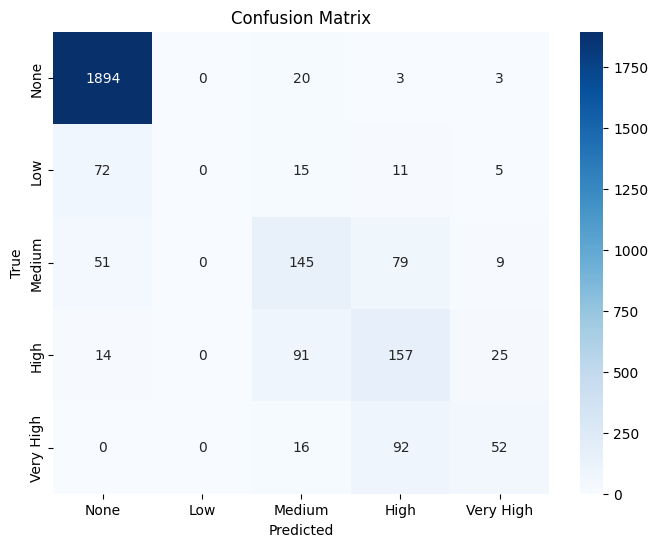

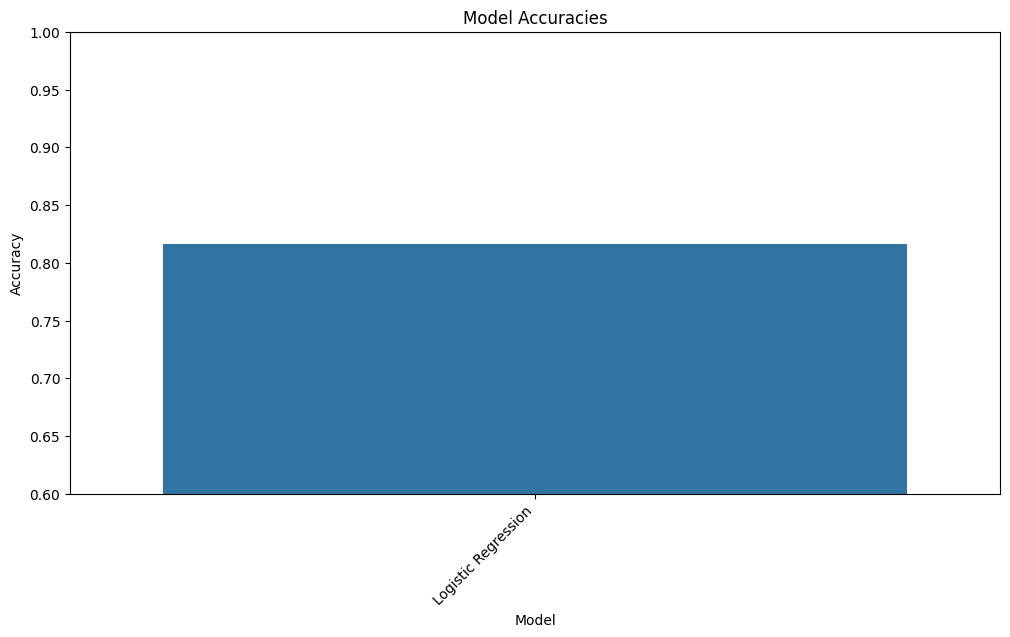

In [10]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=state_value, max_iter=8000)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Calculate accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Print accuracy
print(f'Logistic Regression Accuracy: {accuracy_logreg:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_logreg, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Logistic Regression'] = {'model': logreg_model, 'accuracy': accuracy_logreg}

models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Logistic Regression Weighted**

Logistic Regression with Class Weights Accuracy: 0.7792


c:\Users\despacito\miniconda3\envs\python3.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


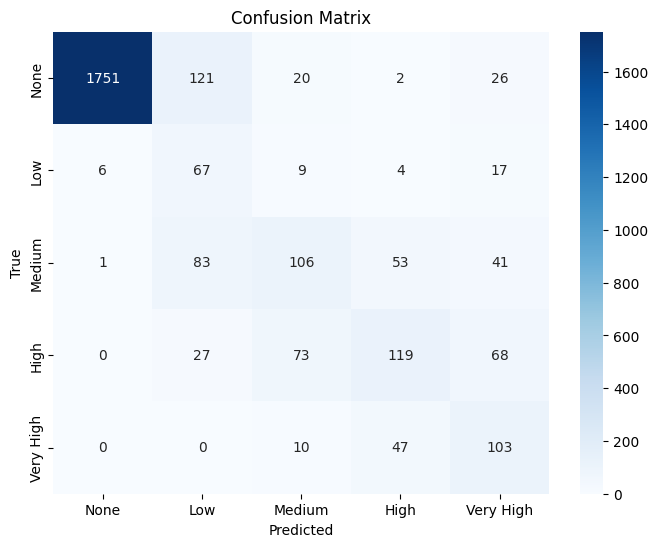

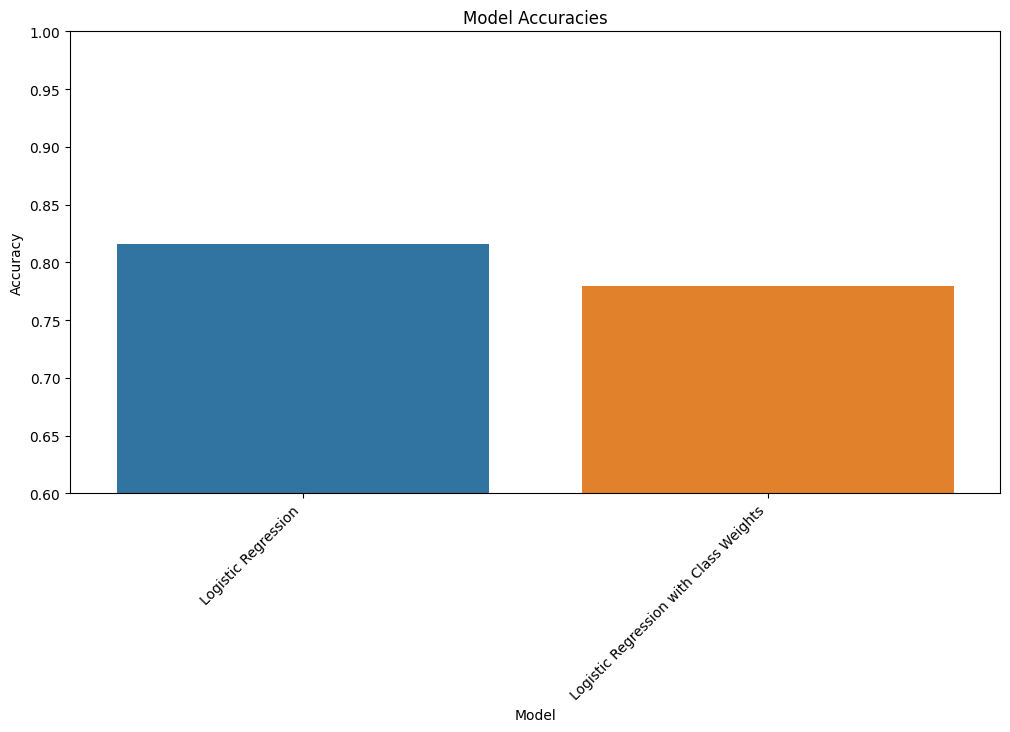

In [11]:
# Initialize another Logistic Regression model with class weights
logreg_model_class_weighted = LogisticRegression(random_state=state_value, max_iter=8000, class_weight=class_weights)

# Train the model
logreg_model_class_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg_class_weighted = logreg_model_class_weighted.predict(X_test)

# Calculate accuracy
accuracy_logreg_class_weighted = accuracy_score(y_test, y_pred_logreg_class_weighted)

# Print accuracy
print(f'Logistic Regression with Class Weights Accuracy: {accuracy_logreg_class_weighted:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_logreg_class_weighted, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Logistic Regression with Class Weights'] = {'model': logreg_model_class_weighted, 'accuracy': accuracy_logreg_class_weighted}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Support Vector Machines (SVM)**

Support Vector Machine Accuracy: 0.8326


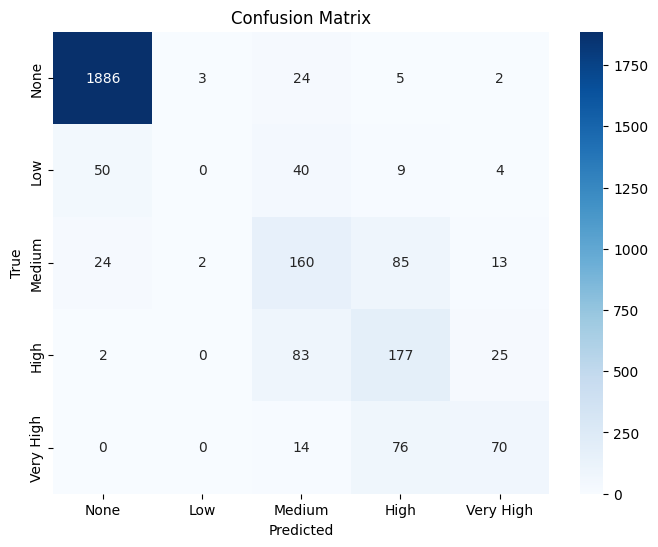

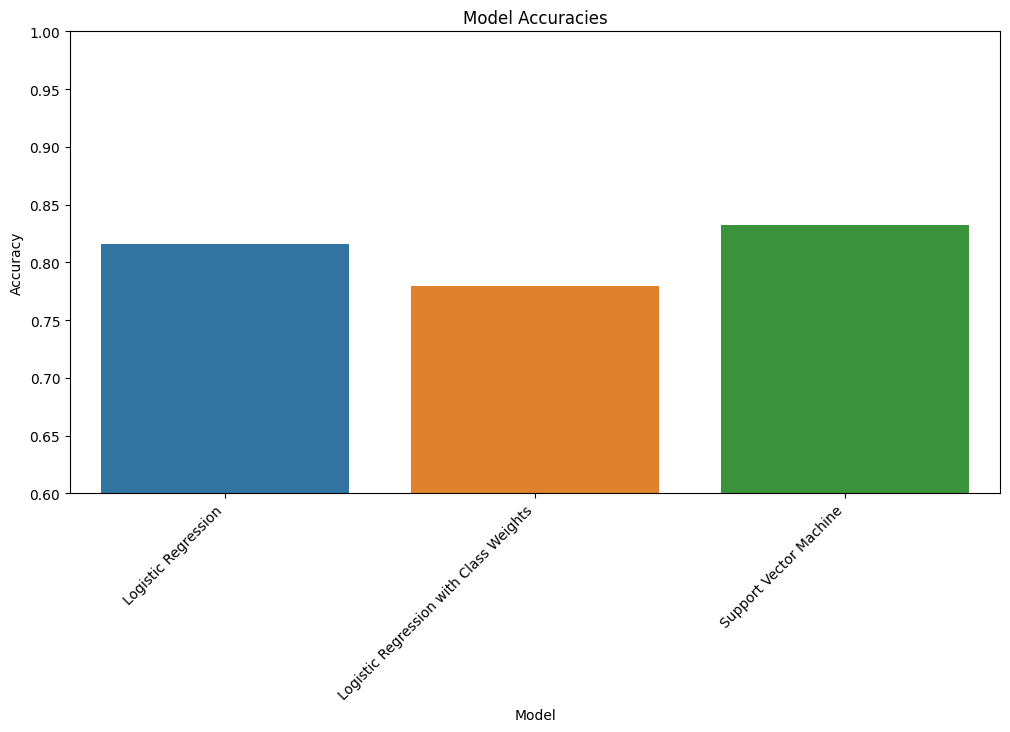

In [12]:
# Standardize the data (feature scaling) using a pipeline
svm_model = make_pipeline(StandardScaler(), SVC(random_state=state_value))

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print accuracy
print(f'Support Vector Machine Accuracy: {accuracy_svm:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Support Vector Machine'] = {'model': svm_model, 'accuracy': accuracy_svm}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Support Vector Machines (SVM) Weighted**

Support Vector Machine with Class Weights Accuracy: 0.8043


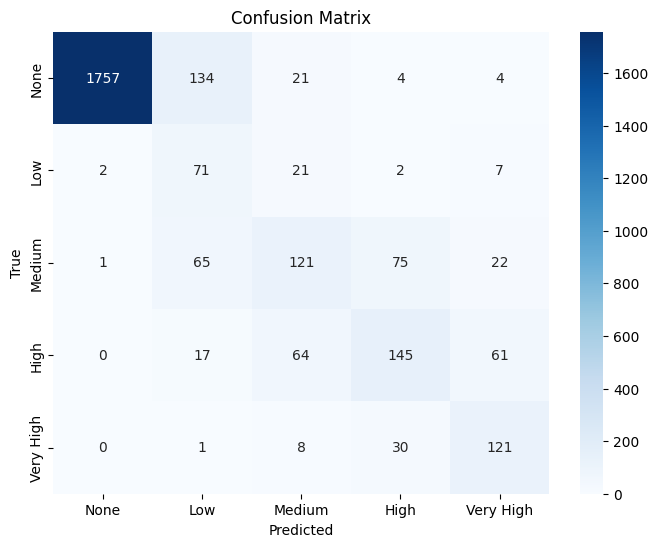

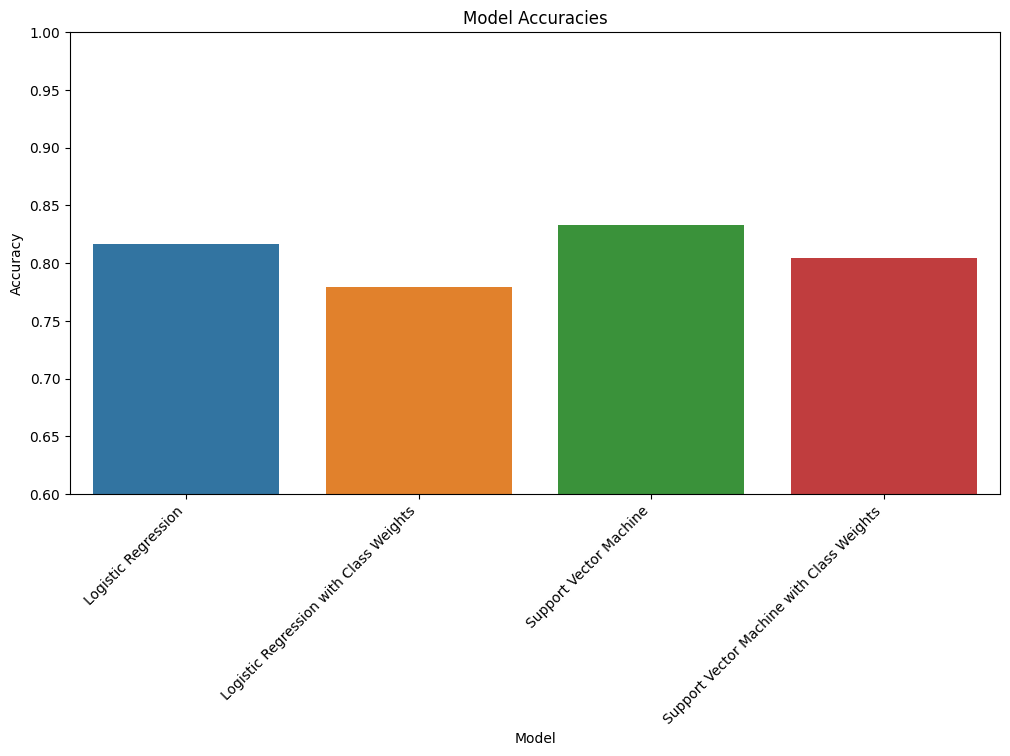

In [13]:
# Initialize the Support Vector Machine model with class weights and feature scaling
svm_model_class_weighted = make_pipeline(StandardScaler(), SVC(random_state=state_value, class_weight=class_weights))

# Train the model
svm_model_class_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm_class_weighted = svm_model_class_weighted.predict(X_test)

# Calculate accuracy
accuracy_svm_class_weighted = accuracy_score(y_test, y_pred_svm_class_weighted)

# Print accuracy
print(f'Support Vector Machine with Class Weights Accuracy: {accuracy_svm_class_weighted:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_svm_class_weighted, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Support Vector Machine with Class Weights'] = {'model': svm_model_class_weighted, 'accuracy': accuracy_svm_class_weighted}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Decision Tree**

Decision Tree Accuracy: 0.8446


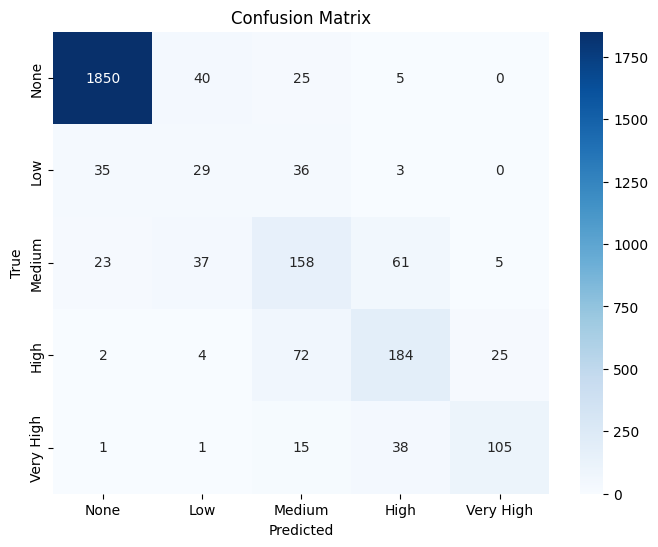

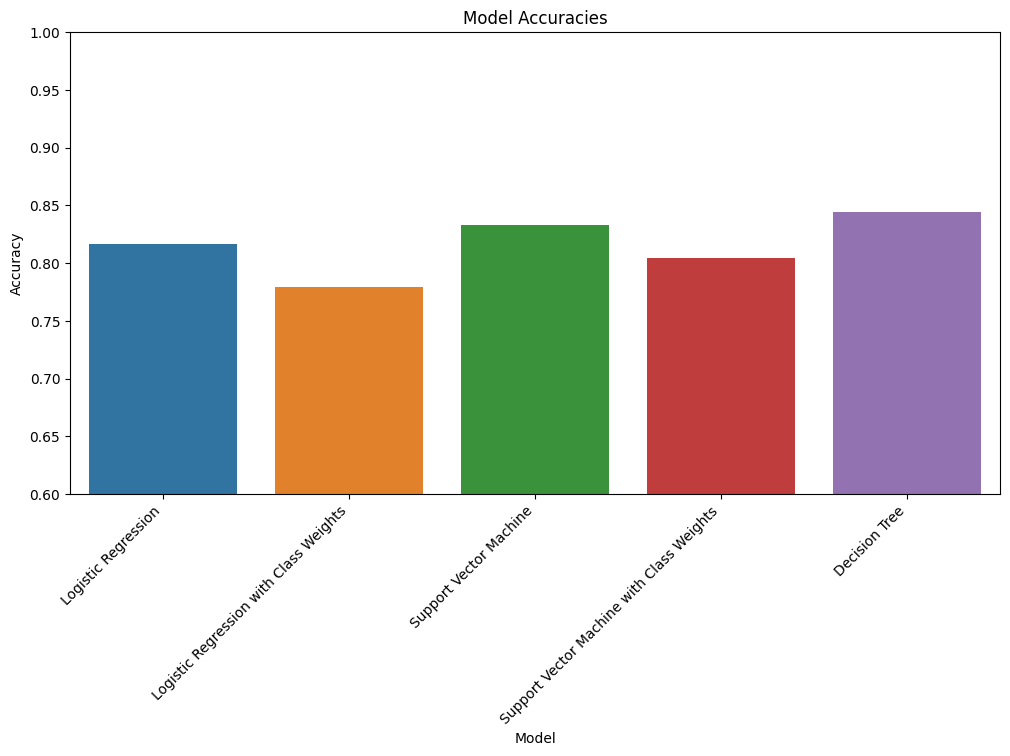

In [14]:
# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=state_value)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tree = tree_model.predict(X_test)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Print accuracy
print(f'Decision Tree Accuracy: {accuracy_tree:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_tree, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Decision Tree'] = {'model': tree_model, 'accuracy': accuracy_tree}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Decision Tree Weighted**

Decision Tree with Class Weights Accuracy: 0.8457


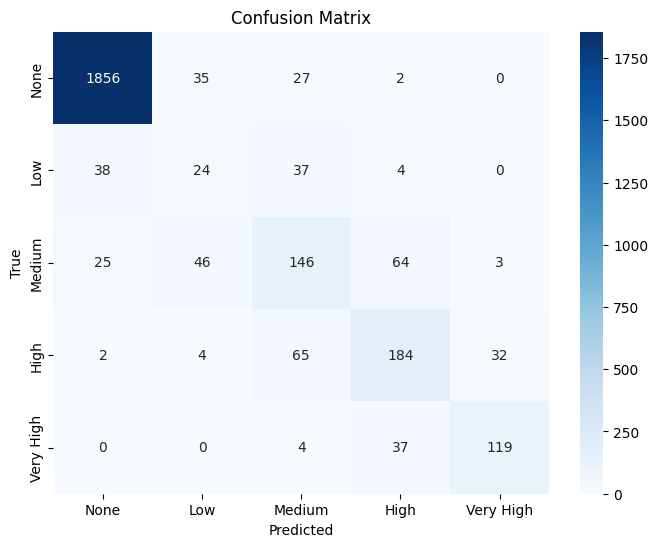

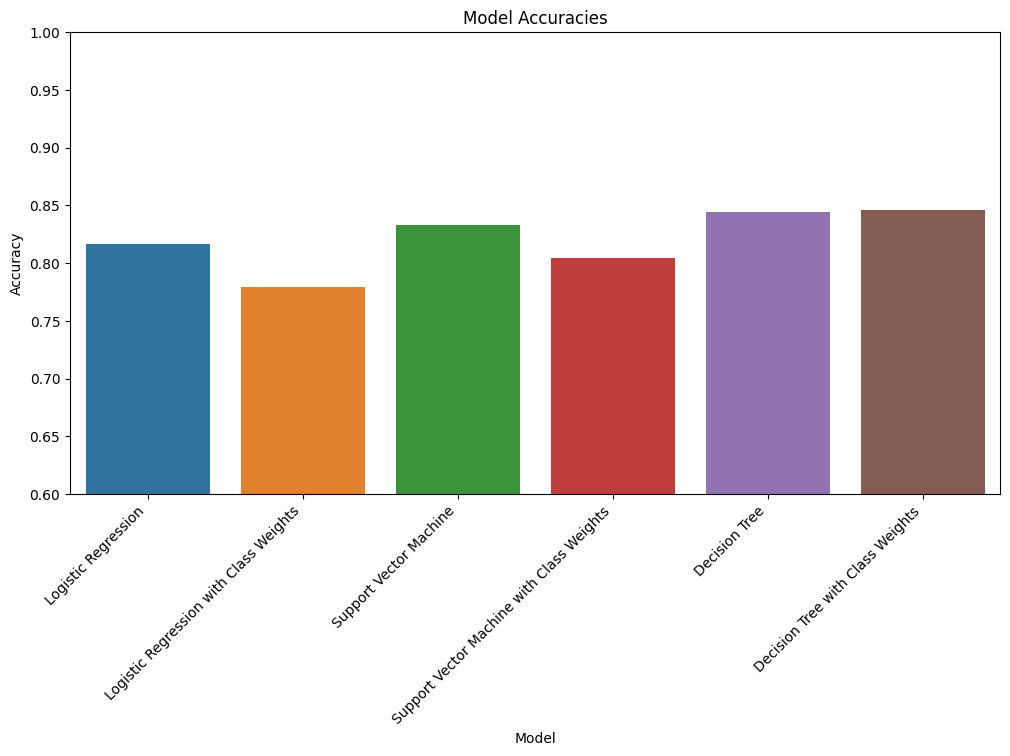

In [15]:
# Initialize the Decision Tree model with class weights
tree_model_class_weighted = DecisionTreeClassifier(random_state=state_value, class_weight=class_weights)

# Train the model
tree_model_class_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tree_class_weighted = tree_model_class_weighted.predict(X_test)

# Calculate accuracy
accuracy_tree_class_weighted = accuracy_score(y_test, y_pred_tree_class_weighted)

# Print accuracy
print(f'Decision Tree with Class Weights Accuracy: {accuracy_tree_class_weighted:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_tree_class_weighted, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Decision Tree with Class Weights'] = {'model': tree_model_class_weighted, 'accuracy': accuracy_tree_class_weighted}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Decision Tree with Grid Search**

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree Accuracy: 0.8555


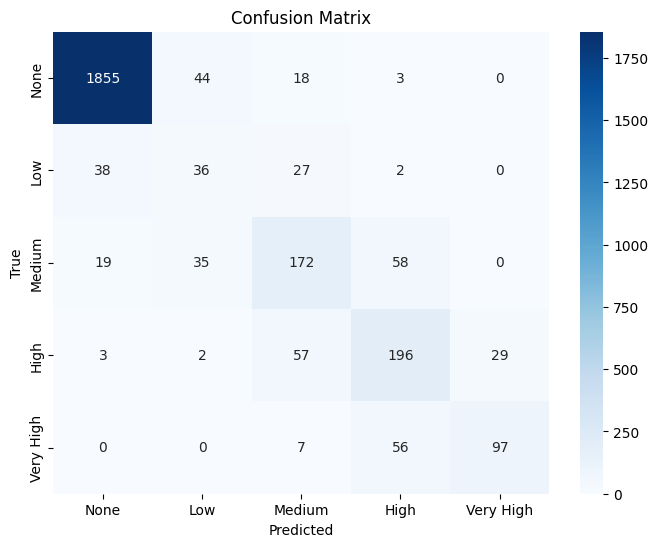

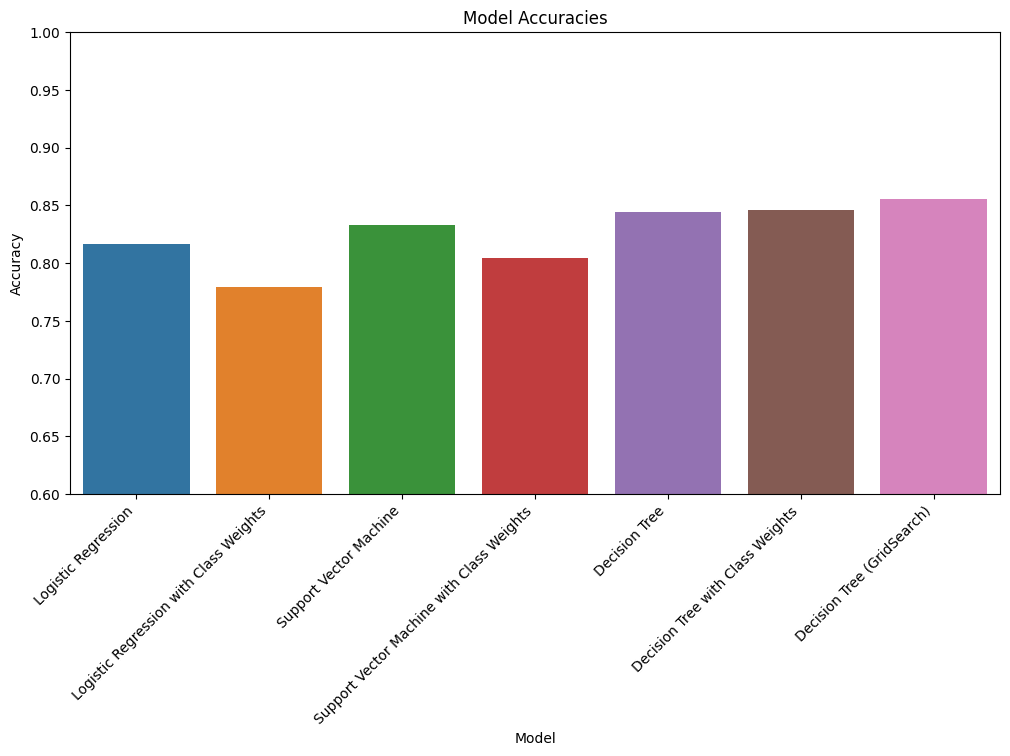

In [16]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=state_value)

# Create GridSearchCV instance
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Make predictions on the test set using the best model
best_tree_model = grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {accuracy_tree:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_tree, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Decision Tree (GridSearch)'] = {'model': best_tree_model, 'accuracy': accuracy_tree}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Decision Tree with Grid Search Weighted**

Best Parameters (with Class Weights): {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Decision Tree Accuracy (with Class Weights): 0.8420


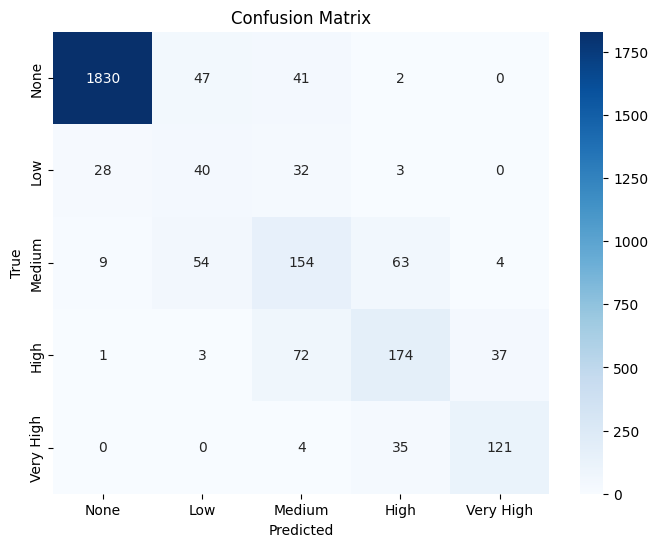

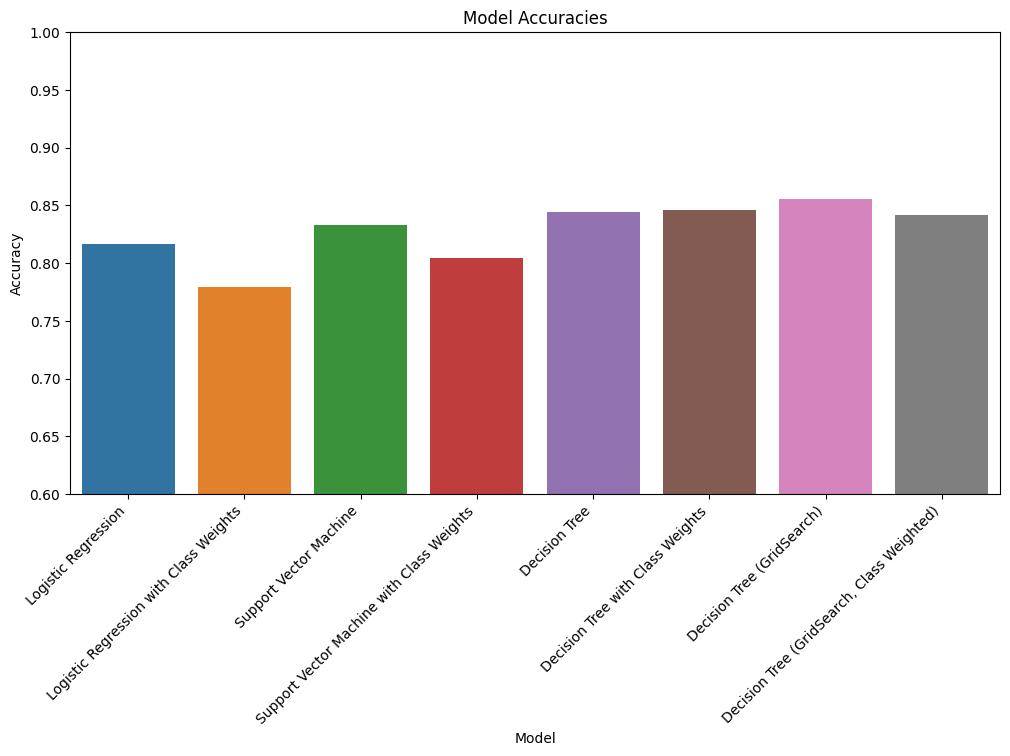

In [18]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model with class weights
tree_model_class_weighted = DecisionTreeClassifier(random_state=state_value, class_weight=class_weights)

# Create GridSearchCV instance
grid_search_class_weighted = GridSearchCV(tree_model_class_weighted, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search_class_weighted.fit(X_train, y_train)

# Get the best parameters
best_params_class_weighted = grid_search_class_weighted.best_params_
print(f'Best Parameters (with Class Weights): {best_params_class_weighted}')

# Make predictions on the test set using the best model
best_tree_model_class_weighted = grid_search_class_weighted.best_estimator_
y_pred_tree_class_weighted = best_tree_model_class_weighted.predict(X_test)

# Calculate accuracy
accuracy_tree_class_weighted = accuracy_score(y_test, y_pred_tree_class_weighted)
print(f'Decision Tree Accuracy (with Class Weights): {accuracy_tree_class_weighted:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_tree_class_weighted, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Decision Tree (GridSearch, Class Weighted)'] = {'model': best_tree_model_class_weighted, 'accuracy': accuracy_tree_class_weighted}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Decision Tree with Grid Search, Weighted, trained on precision**

Best Parameters (with Class Weights, Precision): {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree Accuracy (with Class Weights, Precision): 0.8235


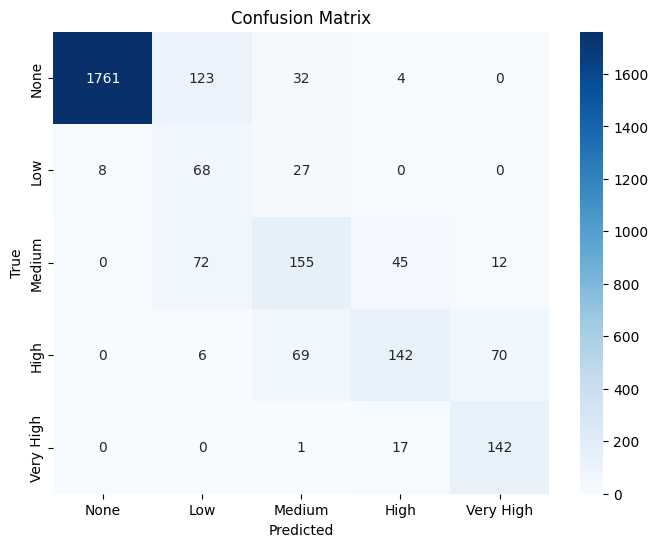

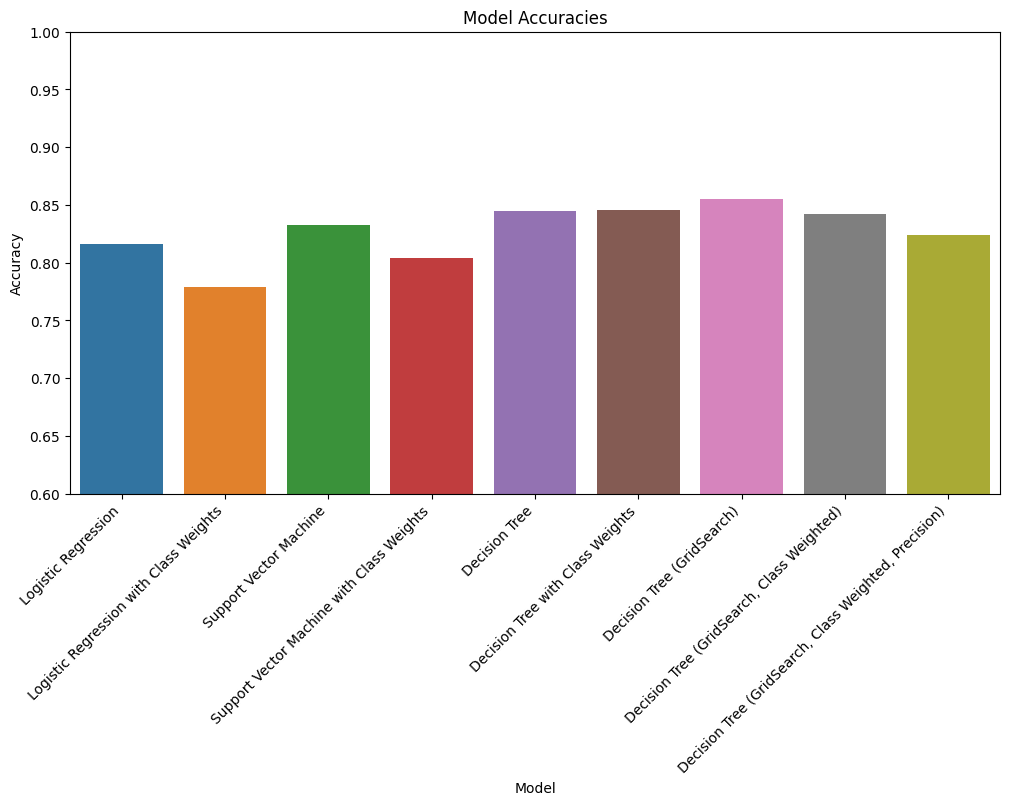

In [21]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model with class weights
tree_model_class_weighted_precision = DecisionTreeClassifier(random_state=state_value, class_weight=class_weights)

# Create GridSearchCV instance with precision as the scoring metric
grid_search_class_weighted_precision = GridSearchCV(tree_model_class_weighted_precision, param_grid, cv=5, scoring='precision_weighted')

# Fit the model to the data
grid_search_class_weighted_precision.fit(X_train, y_train)

# Get the best parameters
best_params_class_weighted_precision = grid_search_class_weighted_precision.best_params_
print(f'Best Parameters (with Class Weights, Precision): {best_params_class_weighted_precision}')

# Make predictions on the test set using the best model
best_tree_model_class_weighted_precision = grid_search_class_weighted_precision.best_estimator_
y_pred_tree_class_weighted_precision = best_tree_model_class_weighted_precision.predict(X_test)

# Calculate accuracy
accuracy_tree_class_weighted_precision = accuracy_score(y_test, y_pred_tree_class_weighted_precision)
print(f'Decision Tree Accuracy (with Class Weights, Precision): {accuracy_tree_class_weighted_precision:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_tree_class_weighted_precision, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Decision Tree (GridSearch, Class Weighted, Precision)'] = {'model': best_tree_model_class_weighted_precision, 'accuracy': accuracy_tree_class_weighted_precision}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Naive Bayes**

Naive Bayes Accuracy: 0.6398


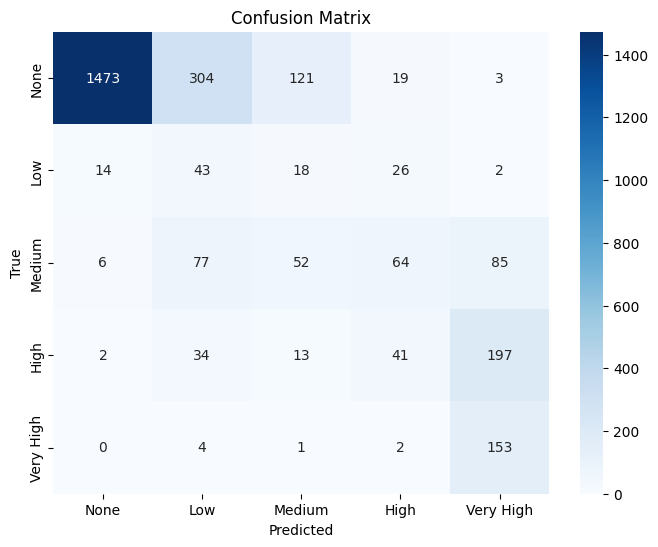

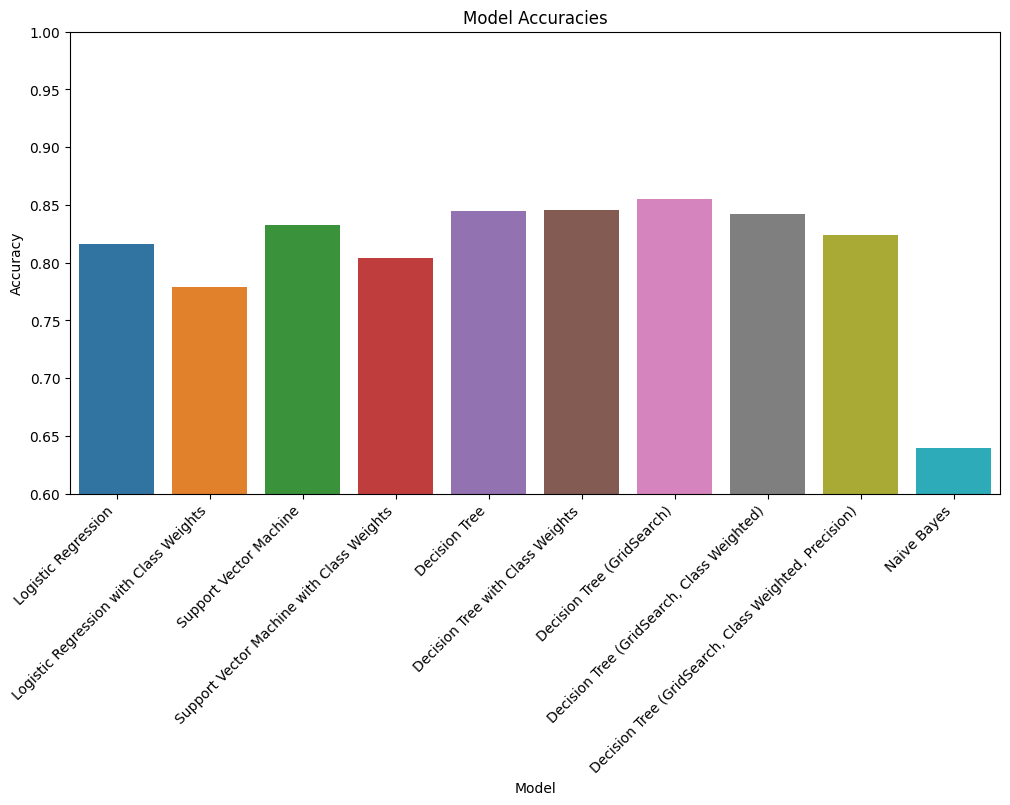

In [22]:
# Initialize the Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the model
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_naive_bayes = naive_bayes_model.predict(X_test)

# Calculate accuracy
accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)

# Print accuracy
print(f'Naive Bayes Accuracy: {accuracy_naive_bayes:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_naive_bayes, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Naive Bayes'] = {'model': naive_bayes_model, 'accuracy': accuracy_naive_bayes}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

(Makes sense sinse Naive Bayes is used on balanced datasets)

## **Random Forest**

Random Forest Accuracy: 0.8704


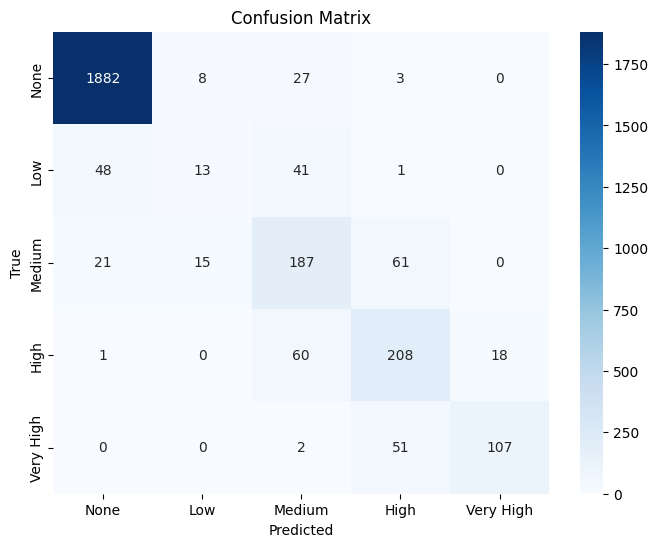

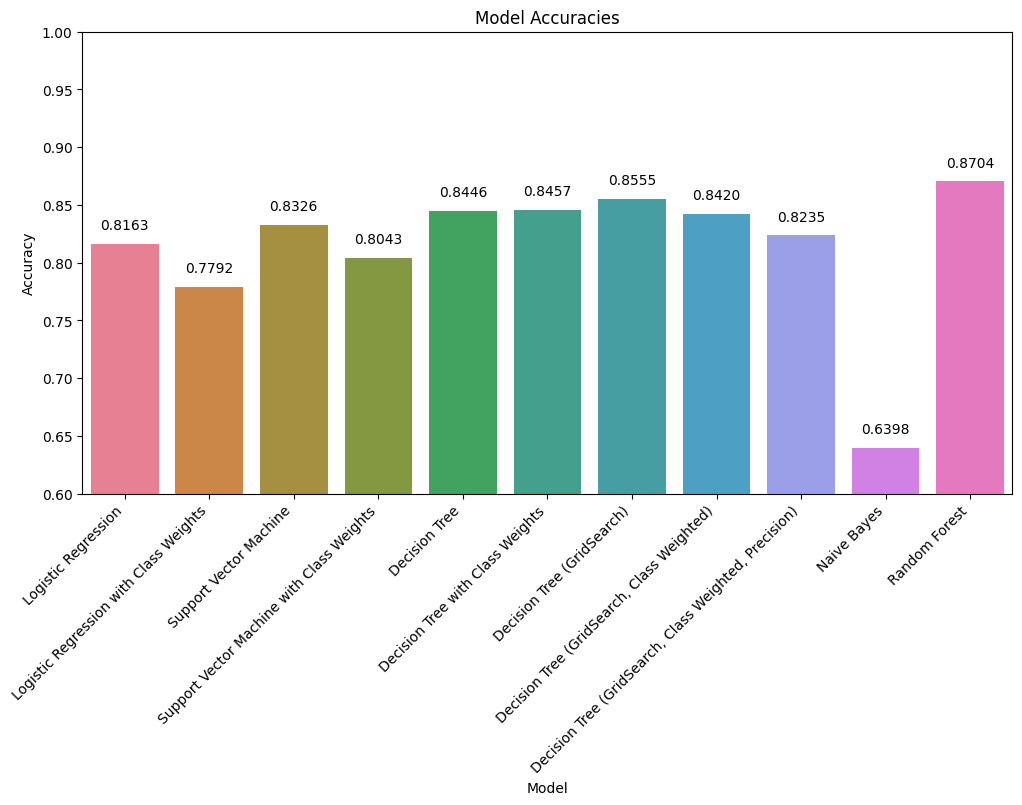

In [32]:
# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=state_value)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_random_forest = random_forest_model.predict(X_test)

# Calculate accuracy
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)

# Print accuracy
print(f'Random Forest Accuracy: {accuracy_random_forest:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_random_forest, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Random Forest'] = {'model': random_forest_model, 'accuracy': accuracy_random_forest}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Random Forest Weighted**

Random Forest with Class Weights Accuracy: 0.8704


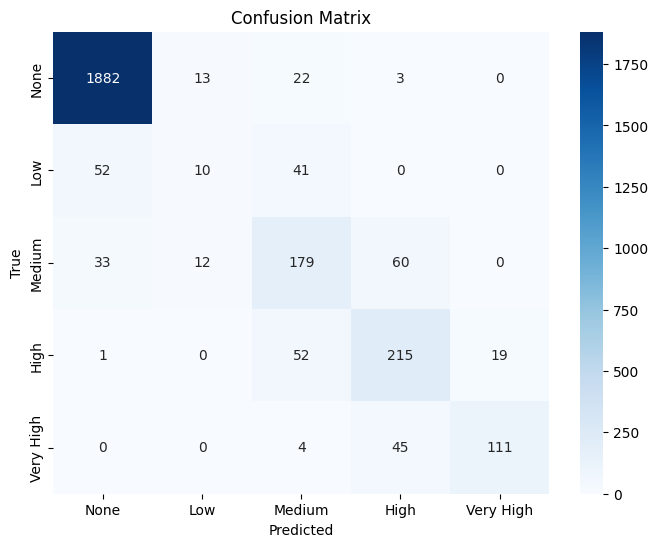

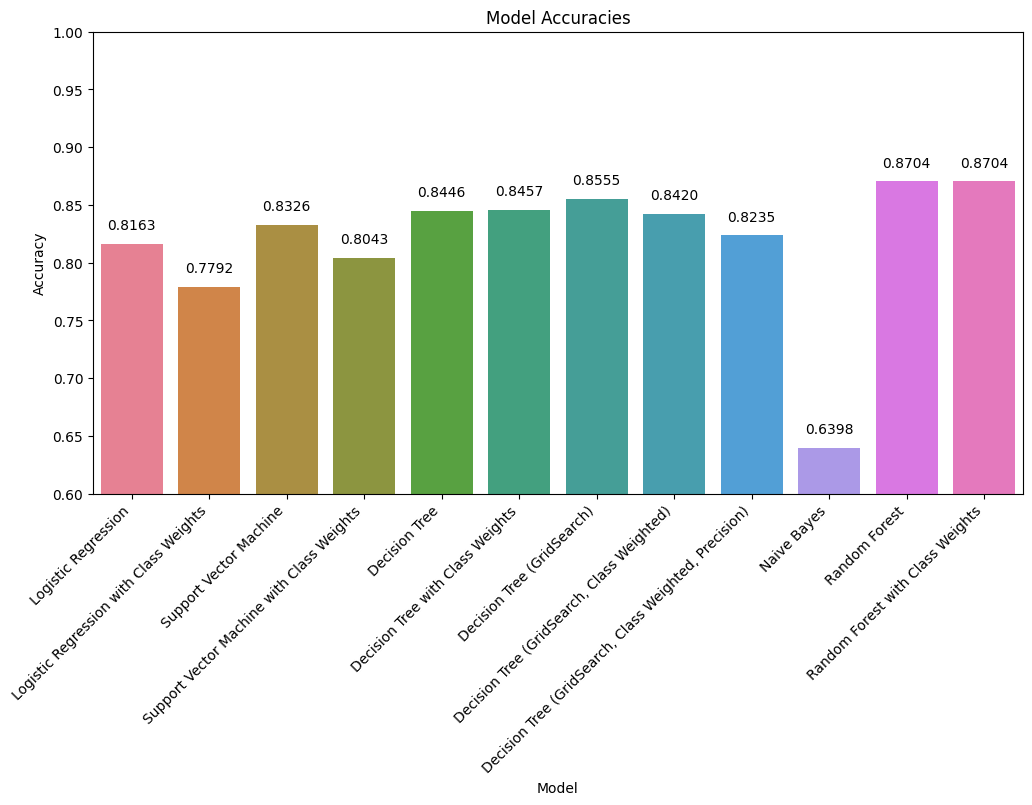

In [35]:
# Initialize the Random Forest model with class weights
random_forest_model_class_weighted = RandomForestClassifier(random_state=state_value, class_weight=class_weights)

# Train the model
random_forest_model_class_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred_random_forest_class_weighted = random_forest_model_class_weighted.predict(X_test)

# Calculate accuracy
accuracy_random_forest_class_weighted = accuracy_score(y_test, y_pred_random_forest_class_weighted)

# Print accuracy
print(f'Random Forest with Class Weights Accuracy: {accuracy_random_forest_class_weighted:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_random_forest_class_weighted, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Random Forest with Class Weights'] = {'model': random_forest_model_class_weighted, 'accuracy': accuracy_random_forest_class_weighted}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Random Forest with Grid Search**

Best Parameters (Random Forest): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Accuracy (GridSearch): 0.8715


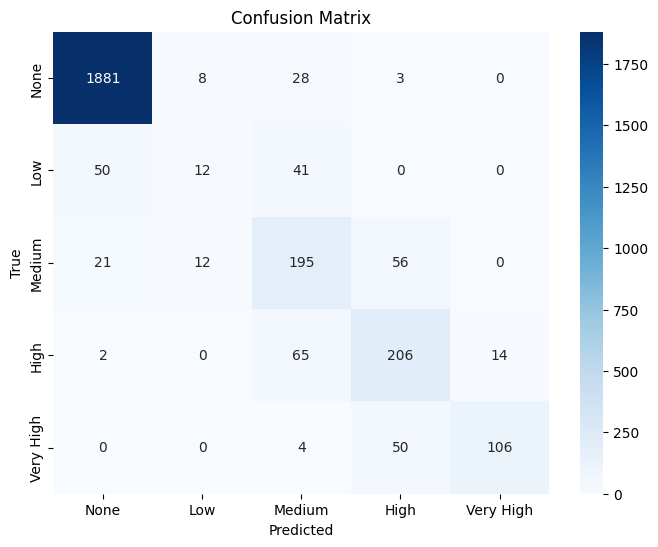

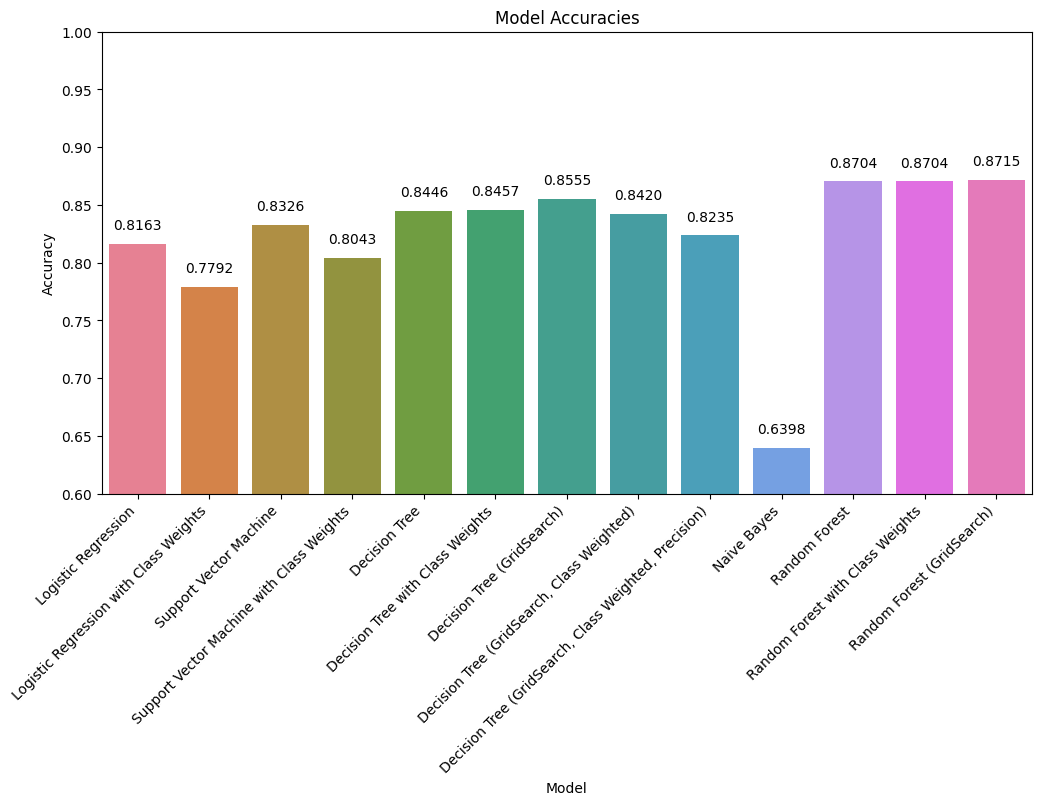

In [37]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=0)

# Create GridSearchCV instance
grid_search_rf = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Parameters (Random Forest): {best_params_rf}')

# Make predictions on the test set using the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy (GridSearch): {accuracy_rf:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Random Forest (GridSearch)'] = {'model': best_rf_model, 'accuracy': accuracy_rf}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

Best Parameters (Random Forest): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150}
Random Forest Accuracy (GridSearch): 0.8718


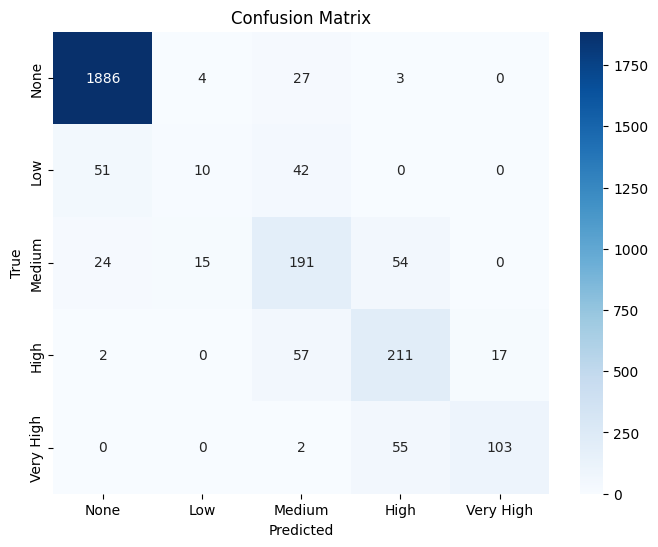

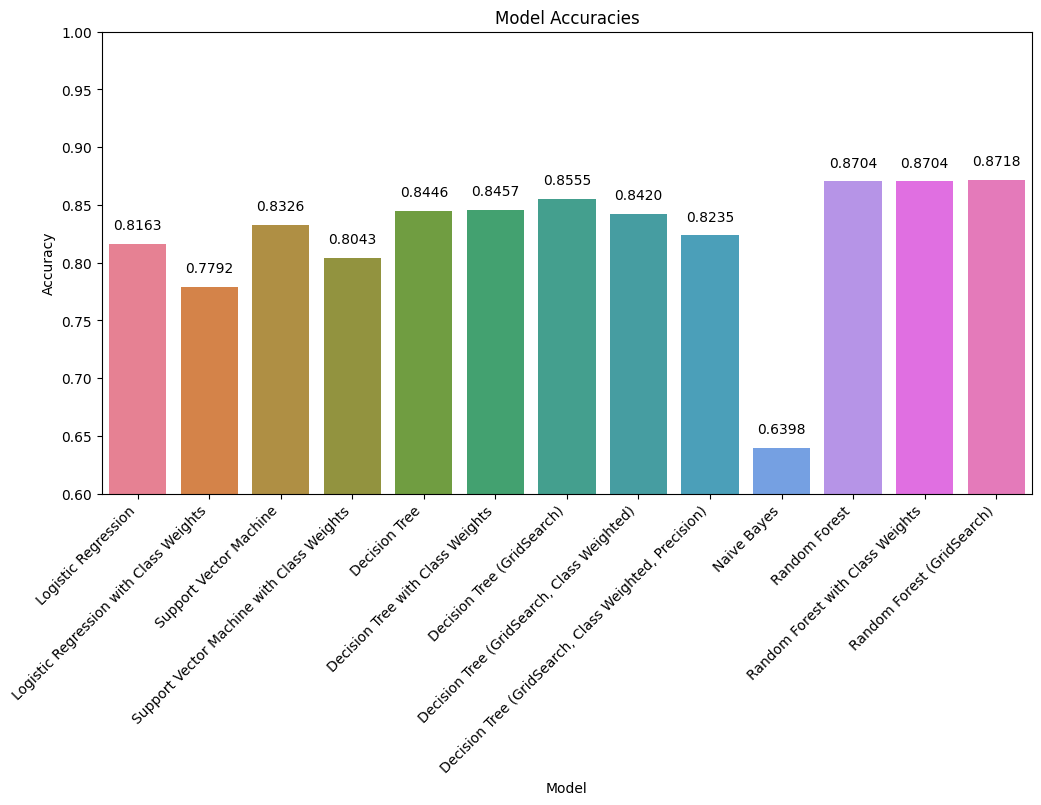

In [41]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [150],
    'max_depth': [20],
    'min_samples_split': [6],
    'min_samples_leaf': [1]
}

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=state_value)

# Create GridSearchCV instance
grid_search_rf = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Parameters (Random Forest): {best_params_rf}')

# Make predictions on the test set using the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy (GridSearch): {accuracy_rf:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Random Forest (GridSearch)'] = {'model': best_rf_model, 'accuracy': accuracy_rf}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Random Forest with Grid Search Weighted**

Best Parameters (Random Forest): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Random Forest Accuracy (GridSearch): 0.8638


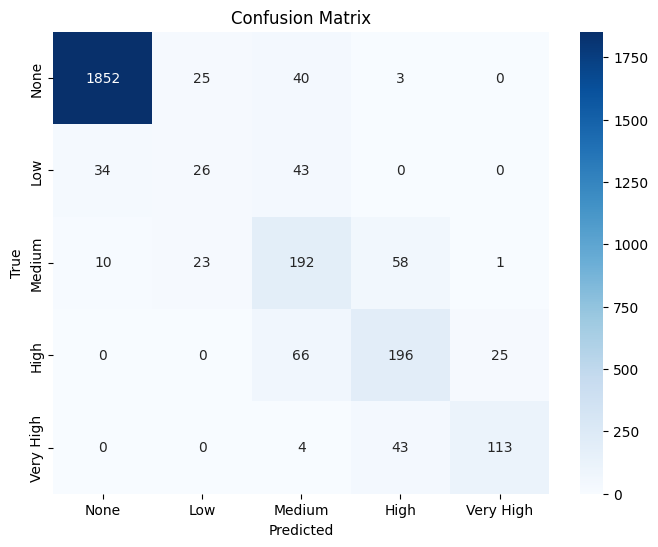

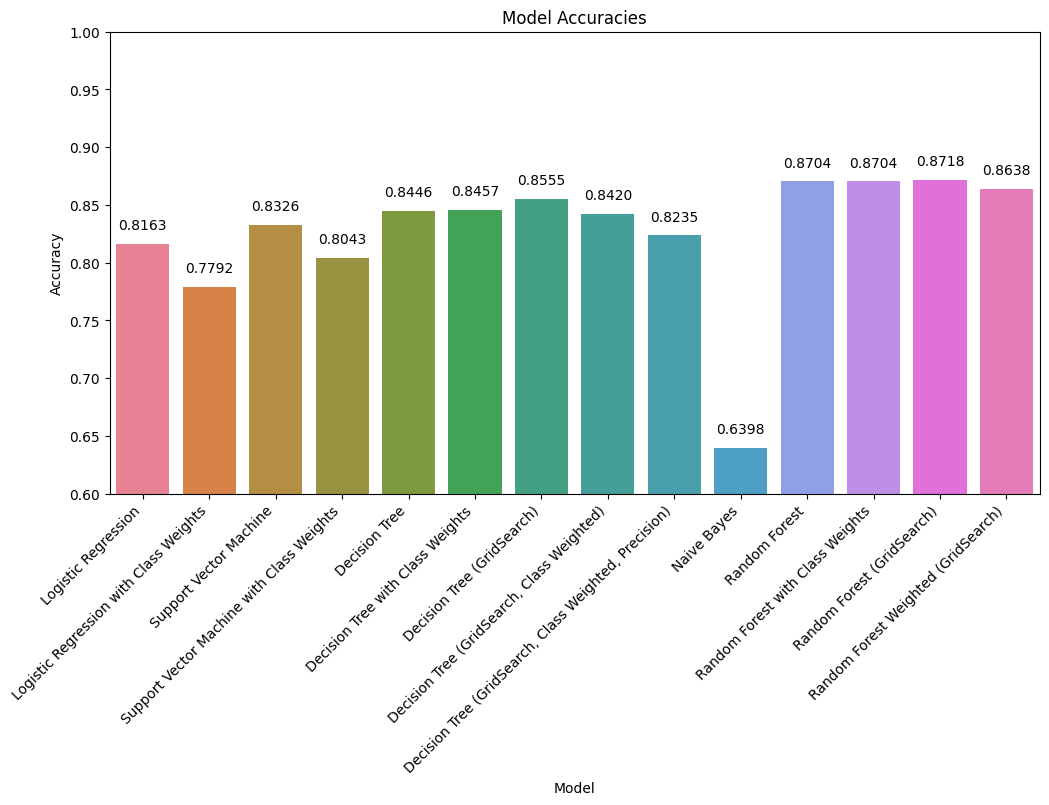

In [43]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [20],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1]
}

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=state_value, class_weight=class_weights)

# Create GridSearchCV instance
grid_search_rf = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Parameters (Random Forest): {best_params_rf}')

# Make predictions on the test set using the best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy (GridSearch): {accuracy_rf:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Random Forest Weighted (GridSearch)'] = {'model': best_rf_model, 'accuracy': accuracy_rf}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **XGBoost**

XGBoost Accuracy: 0.8816


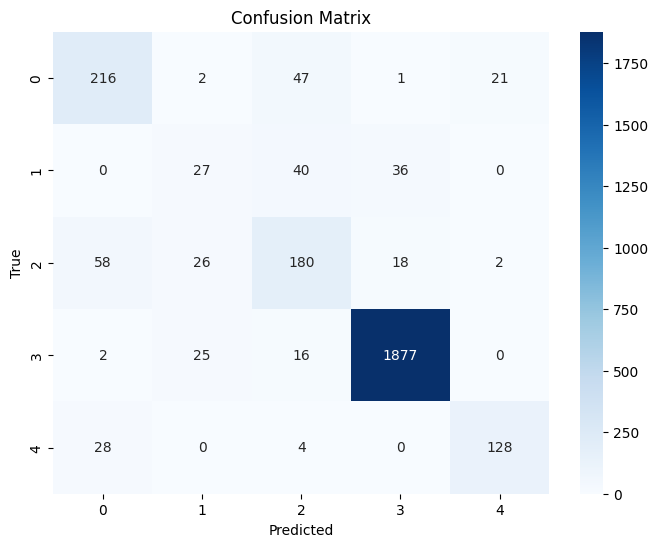

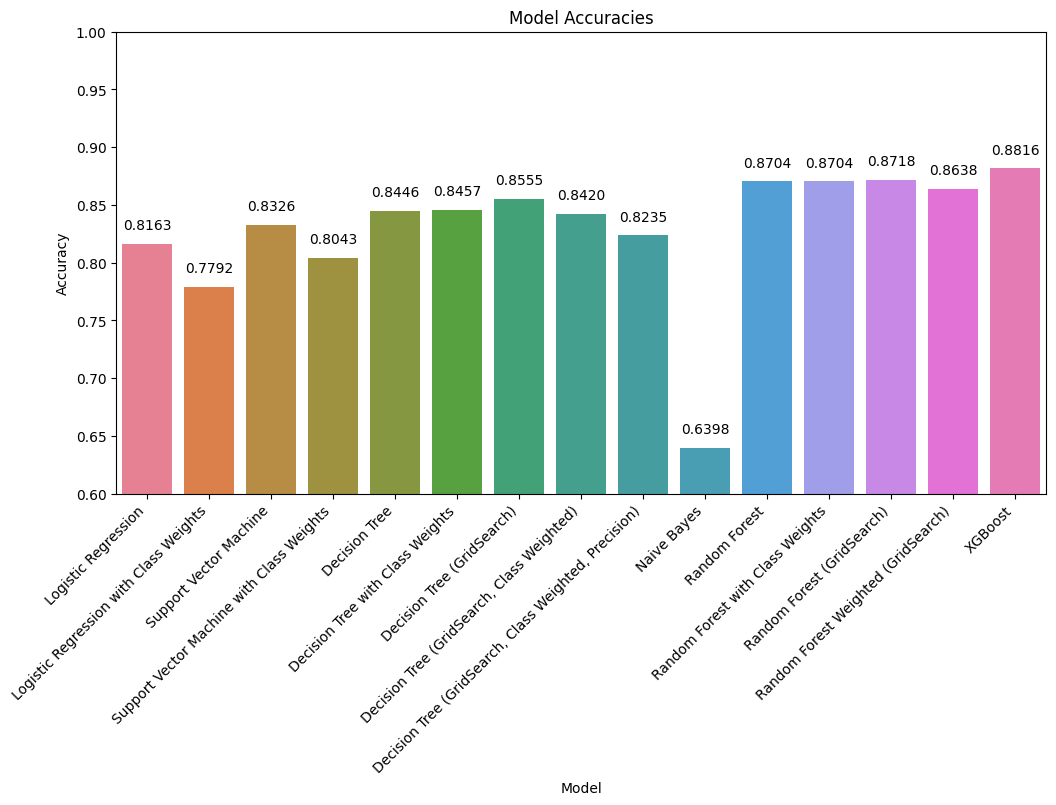

In [48]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable for training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Encode the target variable for test set
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=state_value)

# Train the model
xgb_model.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)

# Print accuracy
print(f'XGBoost Accuracy: {accuracy_xgb:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred_xgb, labels=[0, 1, 2, 3, 4])

# Save the model and its accuracy in the Results dictionary
Results['XGBoost'] = {'model': xgb_model, 'accuracy': accuracy_xgb}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **XGBoost GridSearch**

Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
XGBoost Accuracy (GridSearch): 0.8853


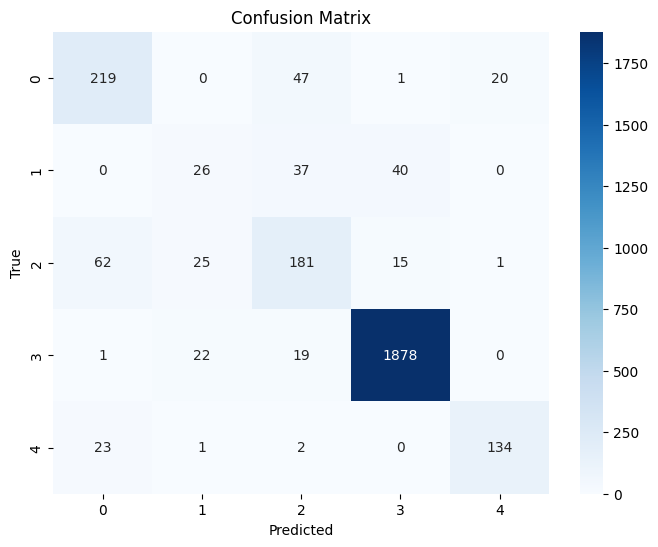

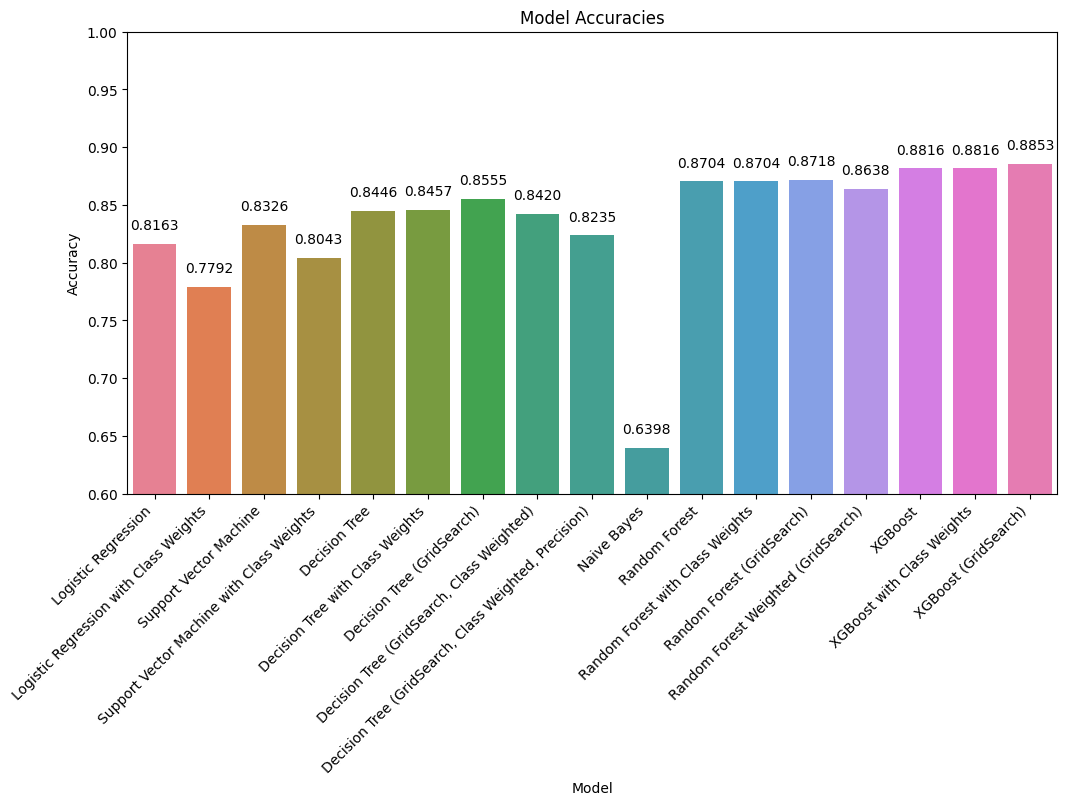

In [50]:
# Encode the target variable for training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Encode the target variable for test set
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Create GridSearchCV instance
grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search_xgb.fit(X_train, y_train_encoded)

# Get the best parameters
best_params_xgb = grid_search_xgb.best_params_
print(f'Best Parameters (XGBoost): {best_params_xgb}')

# Make predictions on the test set using the best model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'XGBoost Accuracy (GridSearch): {accuracy_xgb:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred_xgb, labels=[0, 1, 2, 3, 4])

# Save the best model and its accuracy in the Results dictionary
Results['XGBoost (GridSearch)'] = {'model': best_xgb_model, 'accuracy': accuracy_xgb}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **LightGBM**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 8262, number of used features: 23
[LightGBM] [Info] Start training from score -2.315008
[LightGBM] [Info] Start training from score -3.223364
[LightGBM] [Info] Start training from score -2.317462
[LightGBM] [Info] Start training from score -0.344029
[LightGBM] [Info] Start training from score -2.919103
LightGBM Accuracy: 0.8820


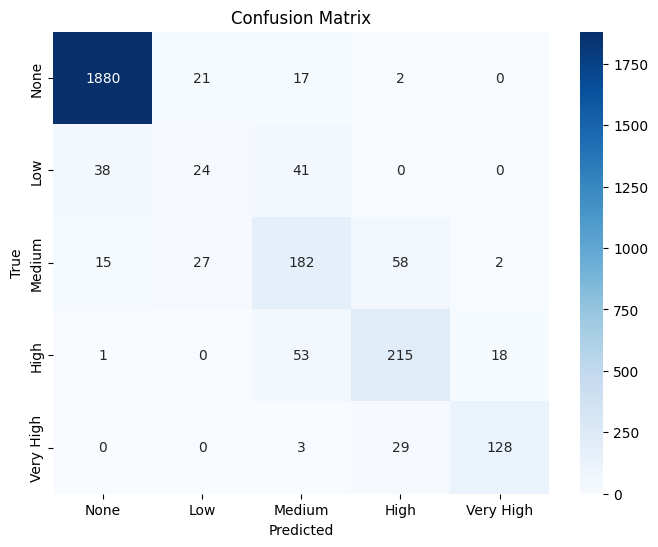

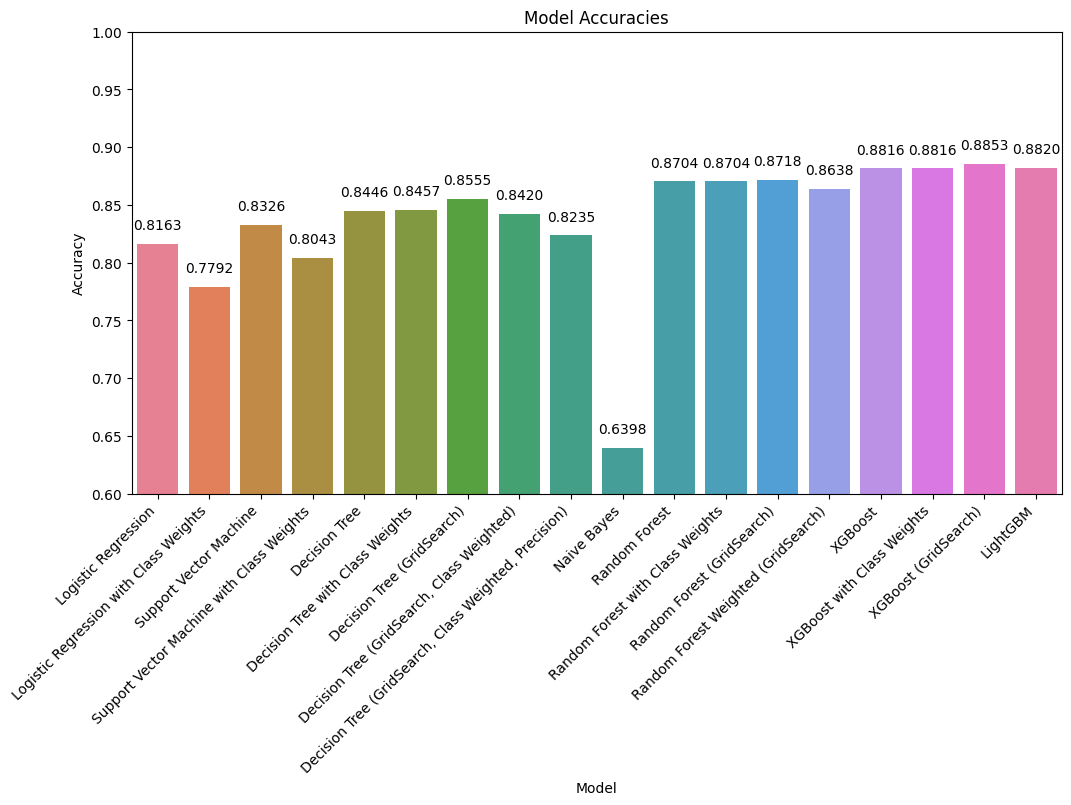

In [51]:
# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=state_value)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

# Print accuracy
print(f'LightGBM Accuracy: {accuracy_lgb:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_lgb, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['LightGBM'] = {'model': lgb_model, 'accuracy': accuracy_lgb}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **LightGBM GridSearch**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 8262, number of used features: 23
[LightGBM] [Info] Start training from score -2.315008
[LightGBM] [Info] Start training from score -3.223364
[LightGBM] [Info] Start training from score -2.317462
[LightGBM] [Info] Start training from score -0.344029
[LightGBM] [Info] Start training from score -2.919103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

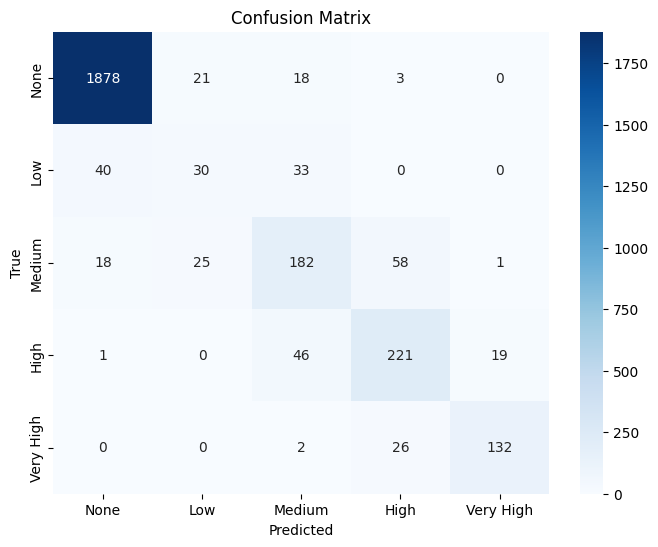

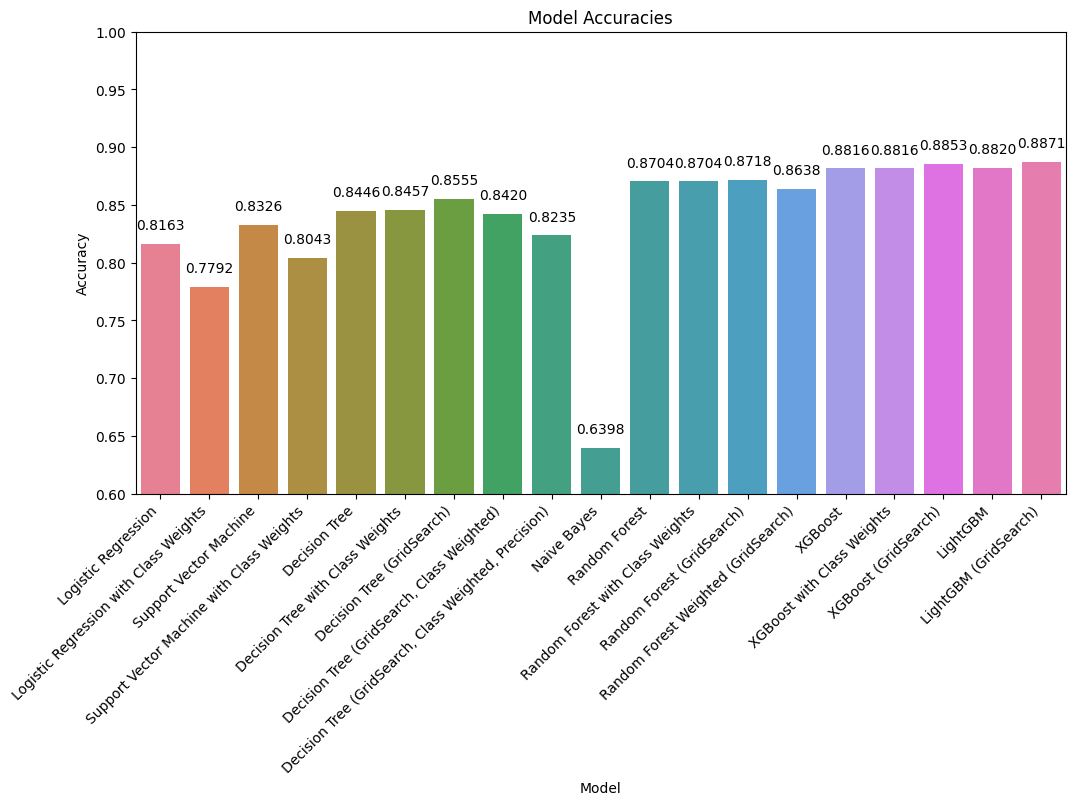

In [52]:
# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=state_value)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [1, 5, 10]
}

# Create GridSearchCV instance
grid_search_lgb = GridSearchCV(lgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search_lgb.fit(X_train, y_train)

# Get the best parameters
best_params_lgb = grid_search_lgb.best_params_
print(f'Best Parameters (LightGBM): {best_params_lgb}')

# Make predictions on the test set using the best model
best_lgb_model = grid_search_lgb.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'LightGBM Accuracy (GridSearch): {accuracy_lgb:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_lgb, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['LightGBM (GridSearch)'] = {'model': best_lgb_model, 'accuracy': accuracy_lgb}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **CatBoost**

0:	learn: 1.4846124	total: 306ms	remaining: 2m 32s
1:	learn: 1.3821051	total: 572ms	remaining: 2m 22s
2:	learn: 1.2964344	total: 825ms	remaining: 2m 16s
3:	learn: 1.2197447	total: 1.09s	remaining: 2m 15s
4:	learn: 1.1514657	total: 1.36s	remaining: 2m 15s
5:	learn: 1.0911625	total: 1.62s	remaining: 2m 13s
6:	learn: 1.0445569	total: 1.88s	remaining: 2m 12s
7:	learn: 0.9987424	total: 2.14s	remaining: 2m 11s
8:	learn: 0.9527238	total: 2.41s	remaining: 2m 11s
9:	learn: 0.9153730	total: 2.68s	remaining: 2m 11s
10:	learn: 0.8807080	total: 2.95s	remaining: 2m 11s
11:	learn: 0.8486232	total: 3.21s	remaining: 2m 10s
12:	learn: 0.8182901	total: 3.5s	remaining: 2m 11s
13:	learn: 0.7901199	total: 3.77s	remaining: 2m 10s
14:	learn: 0.7635447	total: 4.04s	remaining: 2m 10s
15:	learn: 0.7385916	total: 4.34s	remaining: 2m 11s
16:	learn: 0.7158833	total: 4.62s	remaining: 2m 11s
17:	learn: 0.6933802	total: 4.89s	remaining: 2m 10s
18:	learn: 0.6736399	total: 5.16s	remaining: 2m 10s
19:	learn: 0.6534591	to

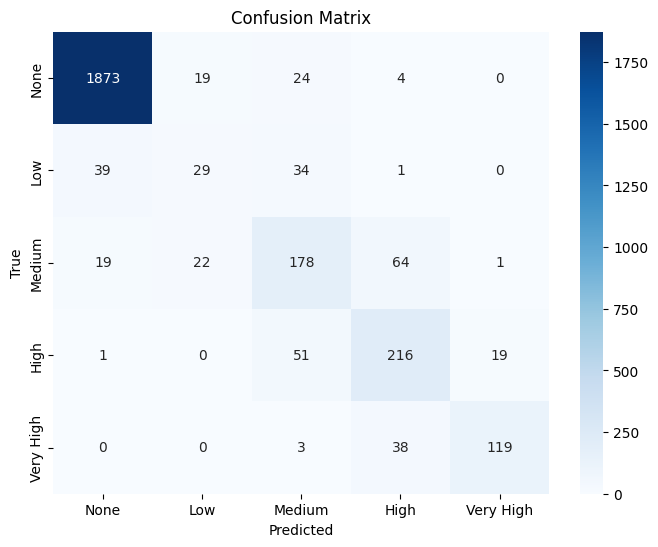

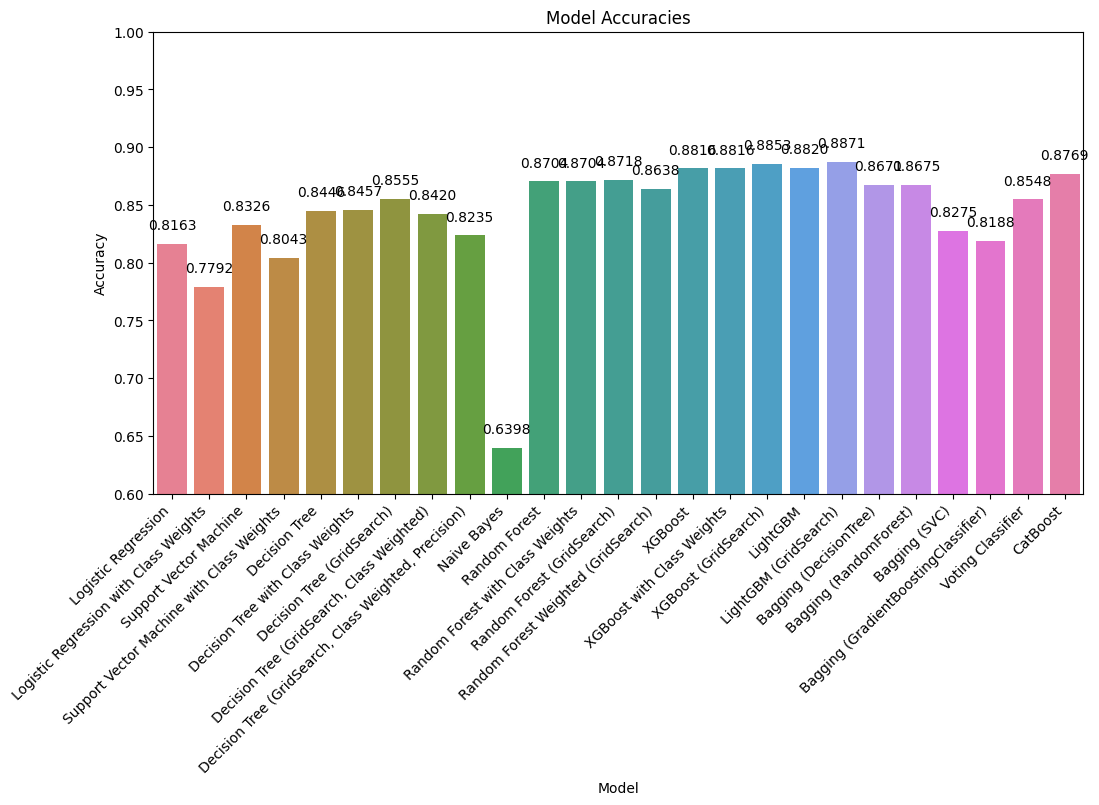

In [66]:
# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, loss_function='MultiClass', random_state=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Calculate accuracy
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f'CatBoost Accuracy: {accuracy_catboost:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_catboost, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['CatBoost'] = {'model': catboost_model, 'accuracy': accuracy_catboost}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Bagging Classifier**

Bagging Accuracy: 0.8671


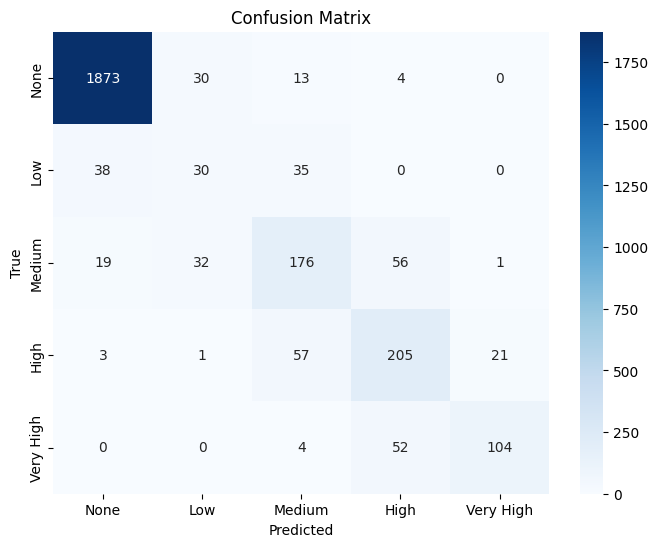

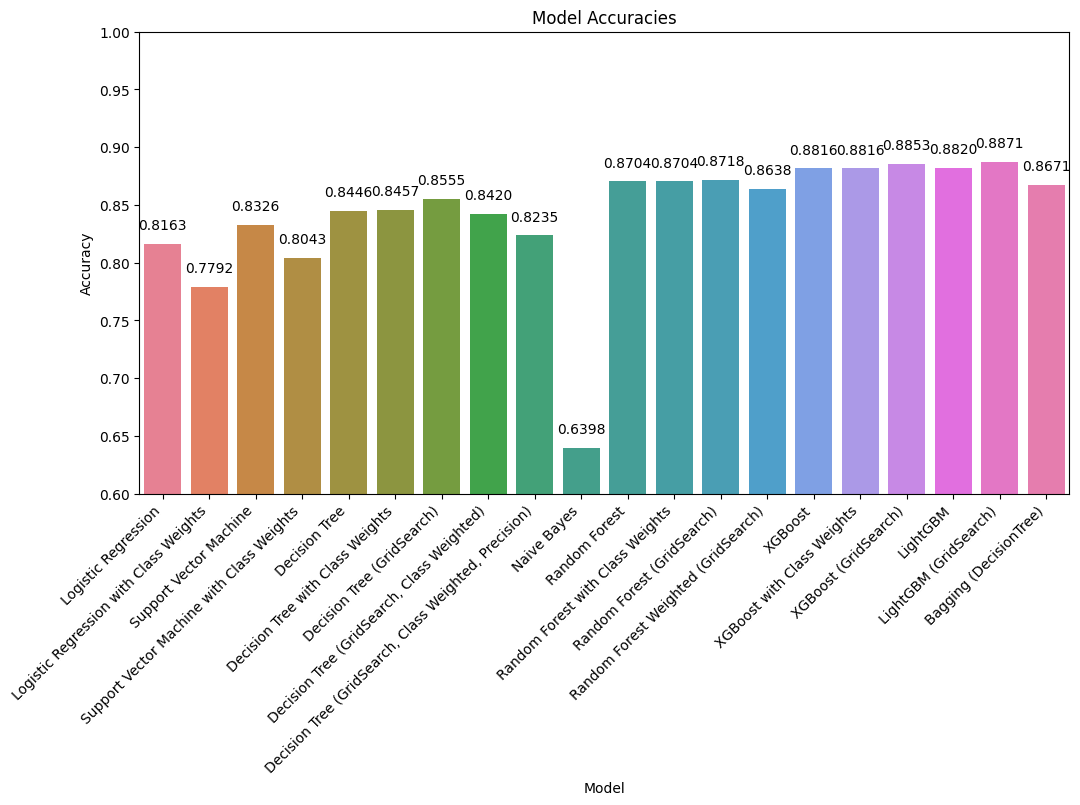

In [54]:
# Choose a base model
base_model = DecisionTreeClassifier(random_state=state_value)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=0)

# Train the BaggingClassifier on the training set
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Accuracy: {accuracy_bagging:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_bagging, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Bagging (DecisionTree)'] = {'model': bagging_model, 'accuracy': accuracy_bagging}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

Bagging Accuracy: 0.8675


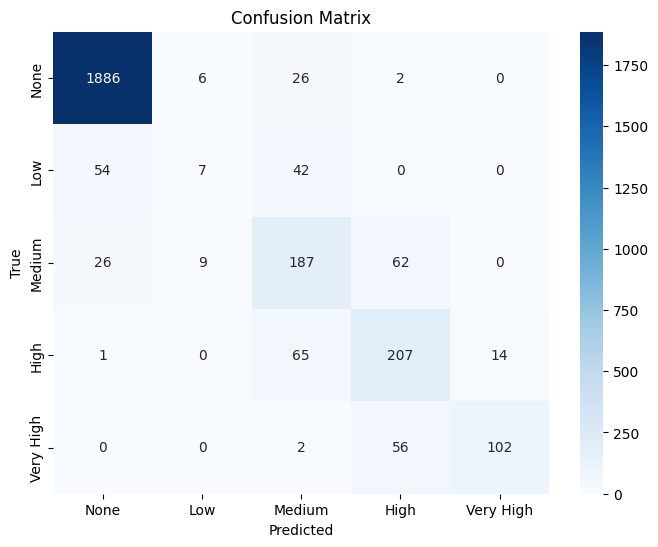

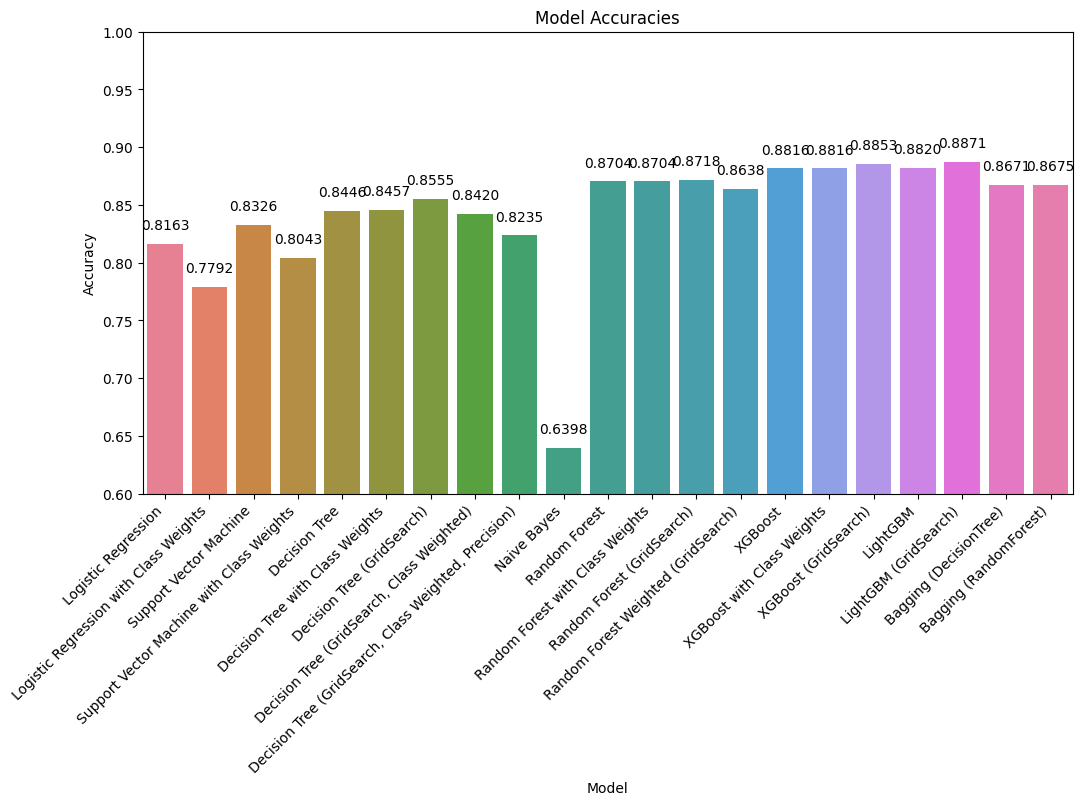

In [55]:
# Choose a base model
base_model = RandomForestClassifier(random_state=state_value)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=0)

# Train the BaggingClassifier on the training set
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Accuracy: {accuracy_bagging:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_bagging, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Bagging (RandomForest)'] = {'model': bagging_model, 'accuracy': accuracy_bagging}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

Bagging Accuracy: 0.8275


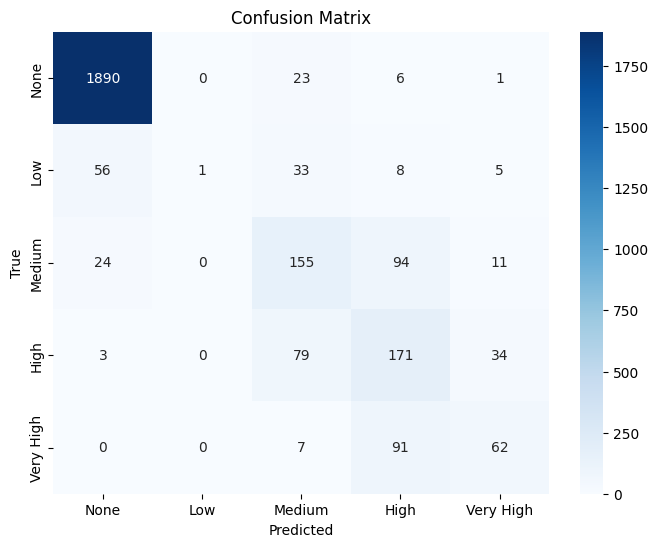

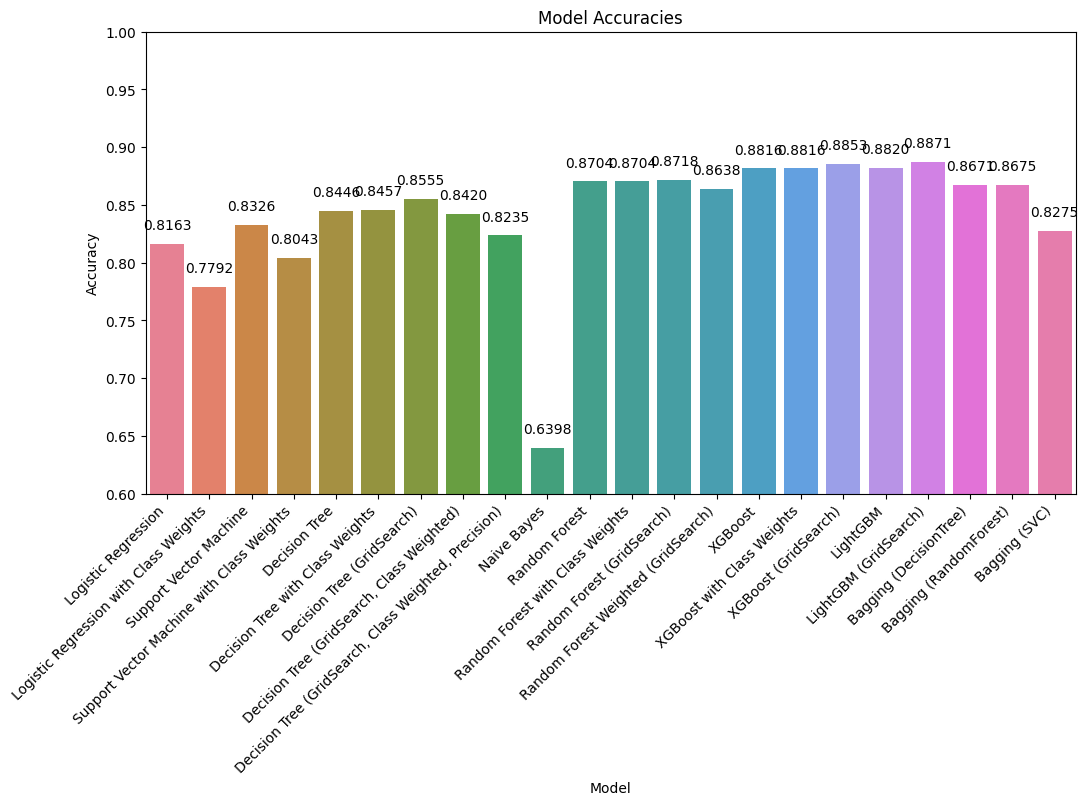

In [56]:
# Choose a base model
base_model = SVC(kernel='linear', random_state=state_value)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=0)

# Train the BaggingClassifier on the training set
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Accuracy: {accuracy_bagging:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_bagging, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Bagging (SVC)'] = {'model': bagging_model, 'accuracy': accuracy_bagging}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

Bagging Accuracy: 0.8744


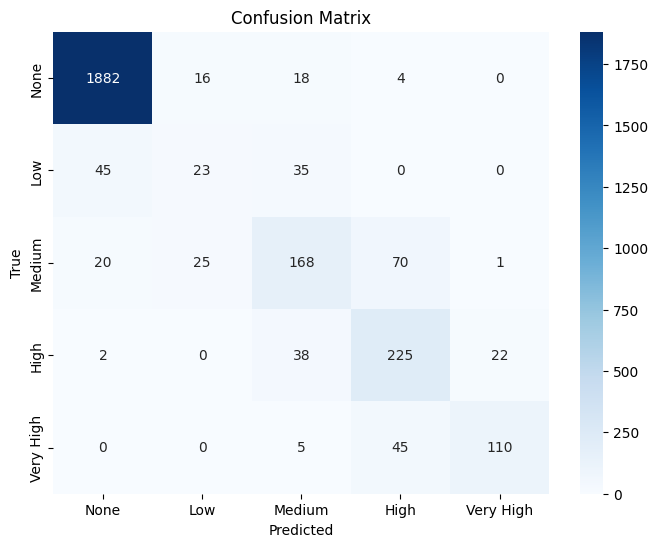

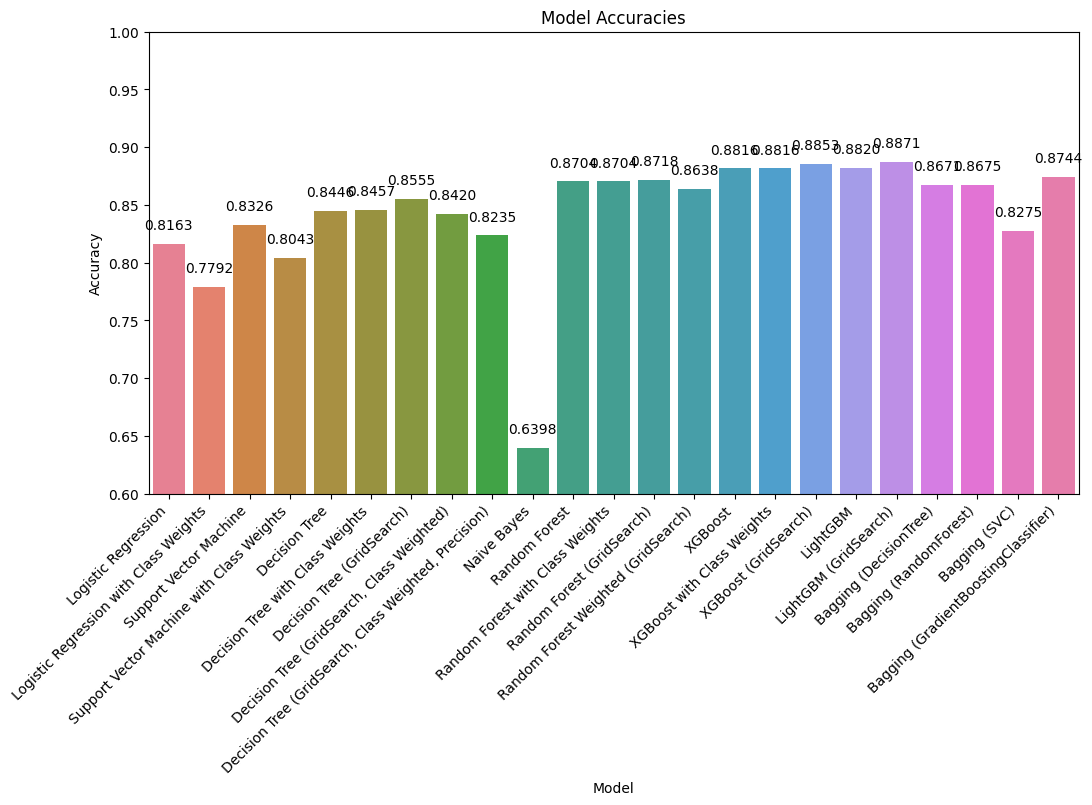

In [59]:
# Choose a base model
base_model = GradientBoostingClassifier(random_state=state_value)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=state_value)

# Train the BaggingClassifier on the training set
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Accuracy: {accuracy_bagging:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_bagging, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Bagging (GradientBoostingClassifier)'] = {'model': bagging_model, 'accuracy': accuracy_bagging}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

Bagging Accuracy: 0.8188


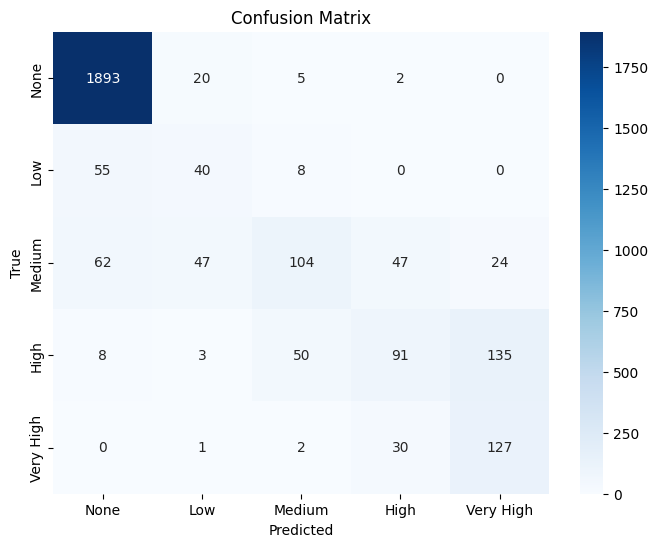

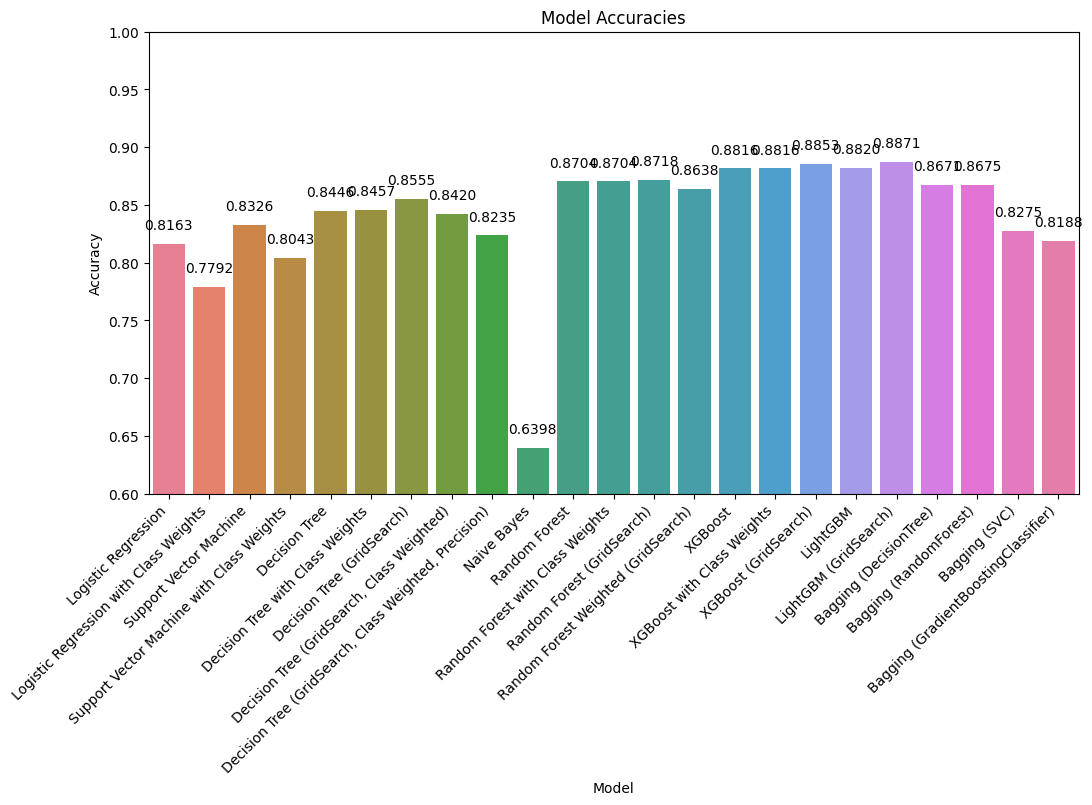

In [60]:
# Choose a base model
base_model = AdaBoostClassifier(random_state=state_value)

# Initialize the BaggingClassifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=state_value)

# Train the BaggingClassifier on the training set
bagging_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Accuracy: {accuracy_bagging:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_bagging, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Bagging (GradientBoostingClassifier)'] = {'model': bagging_model, 'accuracy': accuracy_bagging}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Voting Classifier**

Voting Classifier Accuracy: 0.8548


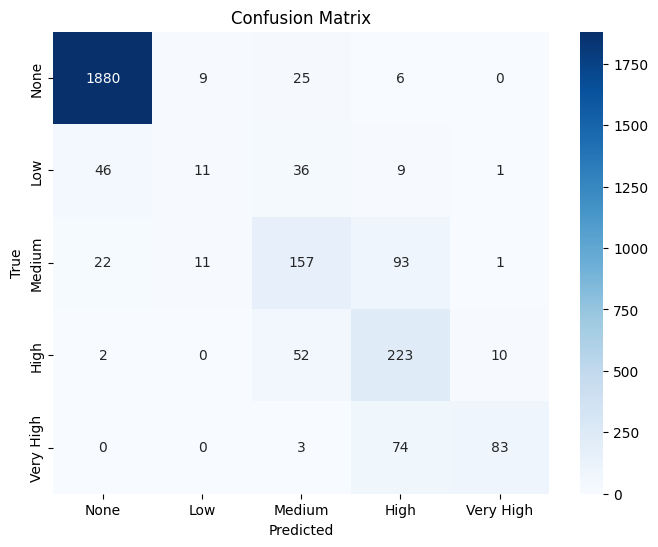

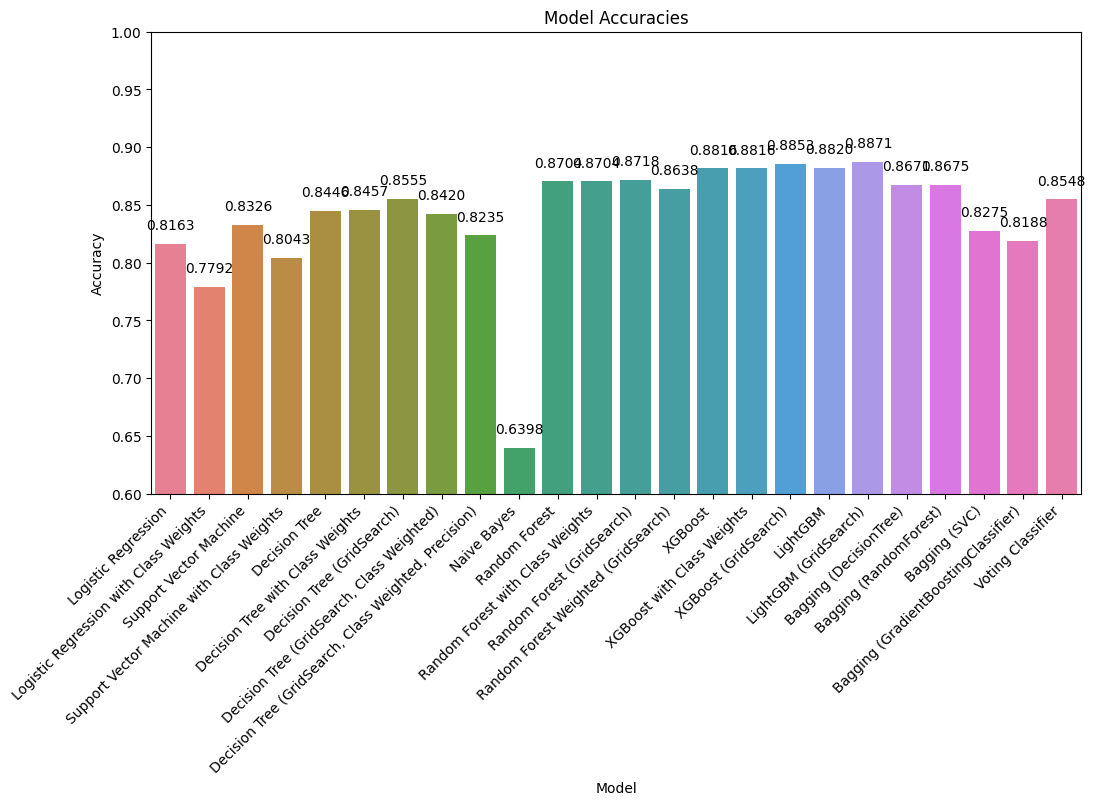

In [63]:
# Define base models
base_model1 = DecisionTreeClassifier(random_state=state_value)
base_model2 = RandomForestClassifier(random_state=state_value)
base_model3 = SVC(kernel='linear', probability=True, random_state=state_value)
base_model4 = KNeighborsClassifier()

# Initialize the VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('model1', base_model1),
        ('model2', base_model2),
        ('model3', base_model3),
        ('model4', base_model4)
    ],
    voting='hard'  # Change to 'soft' for soft voting
)

# Train the VotingClassifier on the training set
voting_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_voting = voting_model.predict(X_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Accuracy: {accuracy_voting:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_voting, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['Voting Classifier'] = {'model': voting_model, 'accuracy': accuracy_voting}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **K-Nearest Neighbors**

K-Nearest Neighbors Accuracy: 0.7393


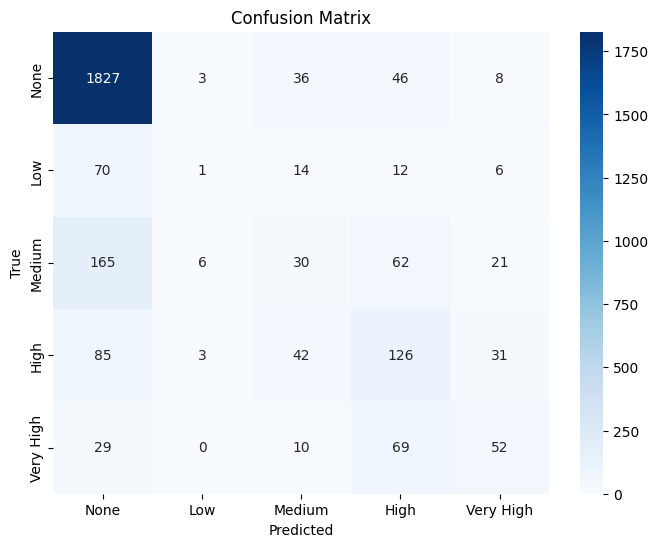

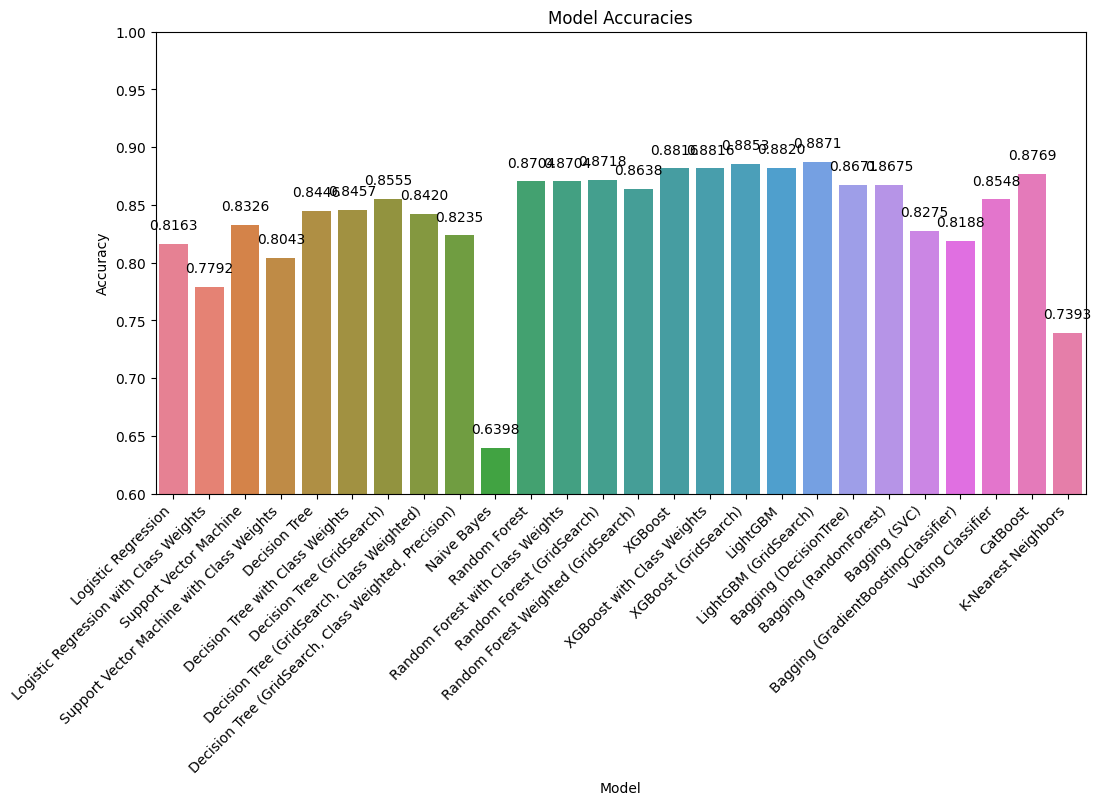

In [73]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=10)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Accuracy: {accuracy_knn:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_knn, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['K-Nearest Neighbors'] = {'model': knn_model, 'accuracy': accuracy_knn}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **K-Nearest Neighbors GridSearch**

Best Parameters: {'n_neighbors': 5}
Best K-Nearest Neighbors Accuracy: 0.7375


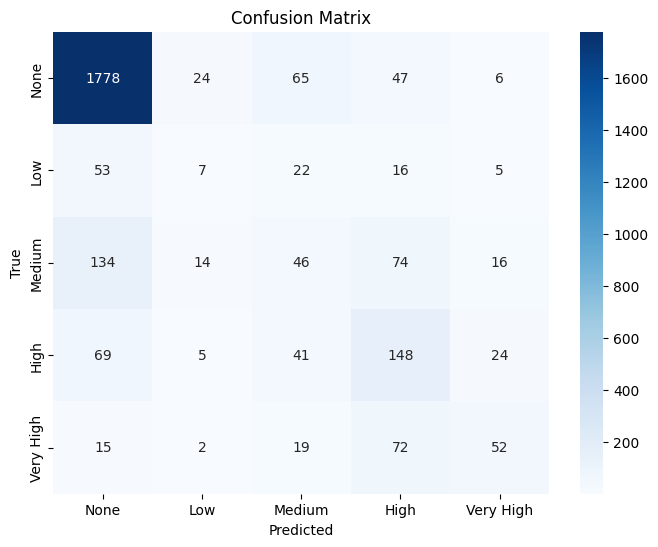

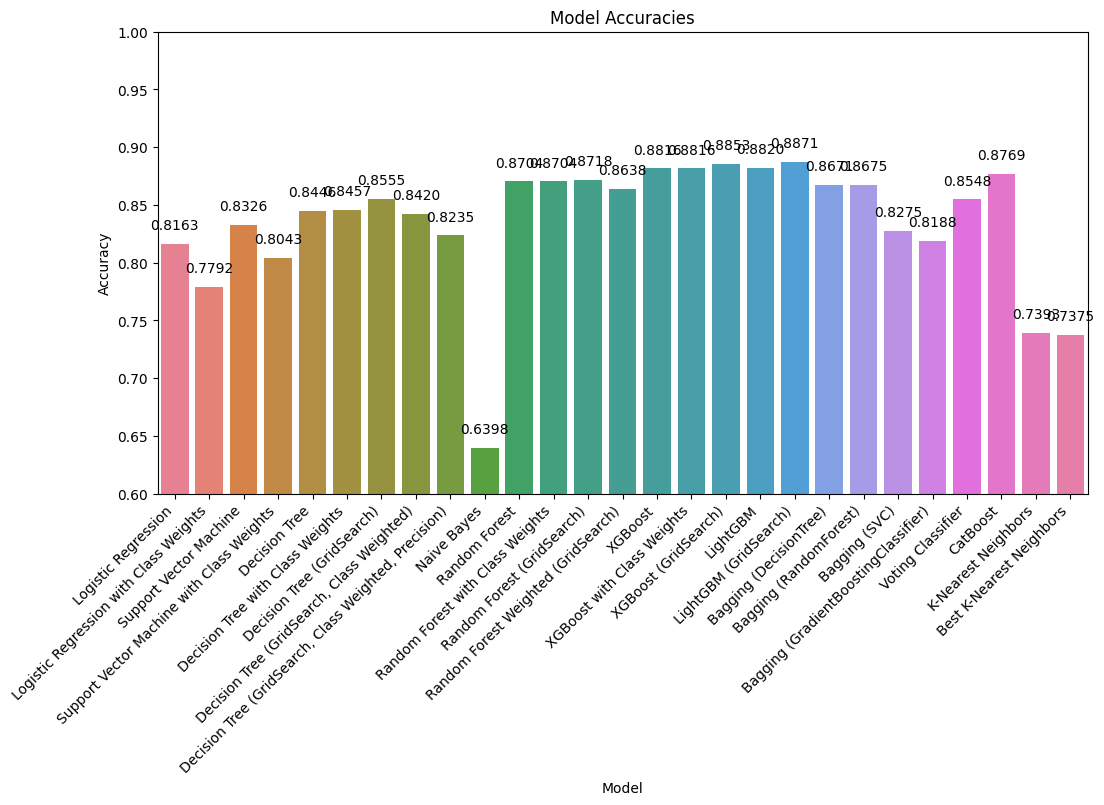

In [74]:
# Define the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best KNN model
best_knn_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_knn_best = best_knn_model.predict(X_test)

# Calculate accuracy
accuracy_knn_best = accuracy_score(y_test, y_pred_knn_best)
print(f'Best K-Nearest Neighbors Accuracy: {accuracy_knn_best:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_knn_best, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['Best K-Nearest Neighbors'] = {'model': best_knn_model, 'accuracy': accuracy_knn_best}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **SGD Classifier**

SGDClassifier Accuracy: 0.6314


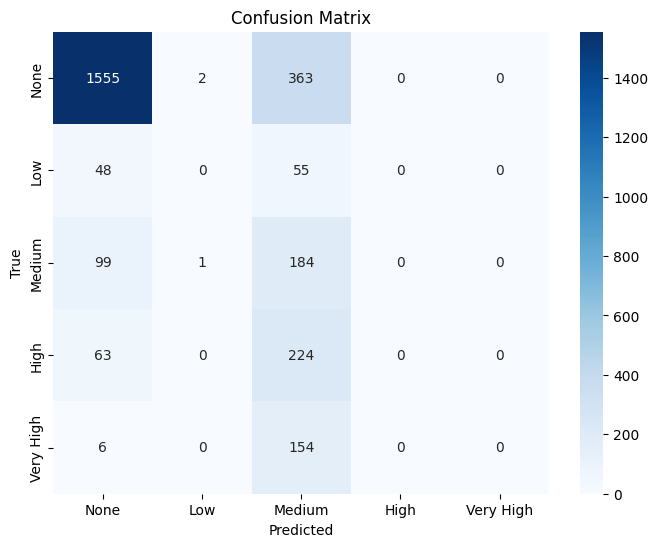

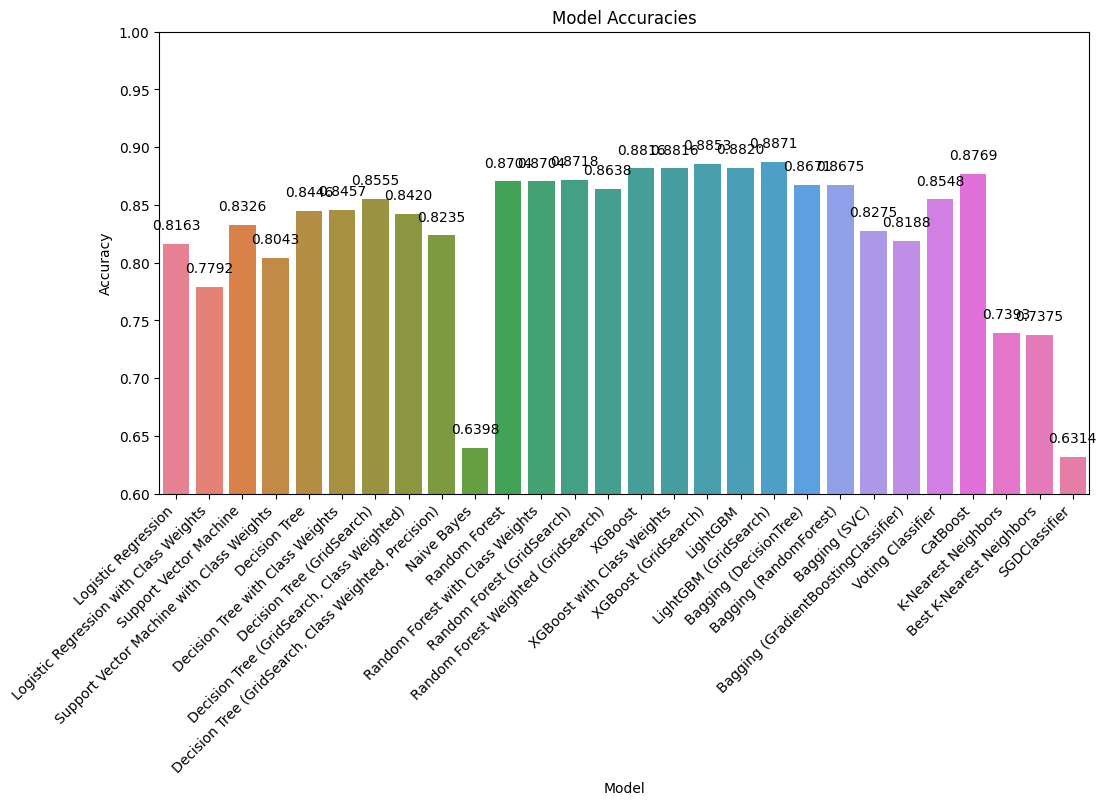

In [76]:
# Initialize the SGDClassifier
sgd_model = SGDClassifier(random_state=state_value, max_iter=1000, tol=1e-3)

# Train the model
sgd_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_sgd = sgd_model.predict(X_test)

# Calculate accuracy
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f'SGDClassifier Accuracy: {accuracy_sgd:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_sgd, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['SGDClassifier'] = {'model': sgd_model, 'accuracy': accuracy_sgd}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **Neural Network**

MLPClassifier Accuracy: 0.7640


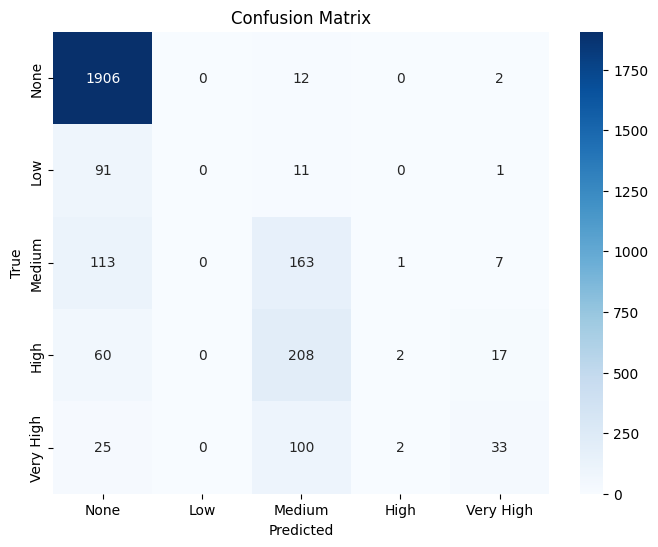

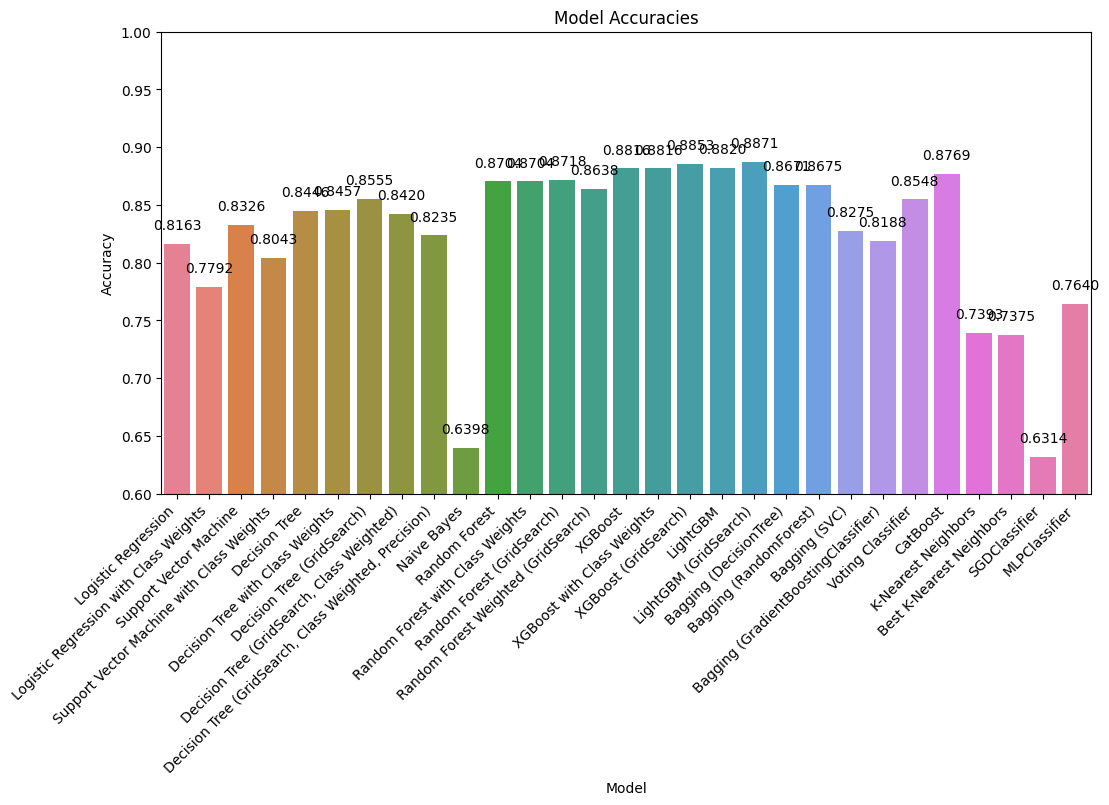

In [78]:
# Initialize the MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=0)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'MLPClassifier Accuracy: {accuracy_mlp:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_mlp, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['MLPClassifier'] = {'model': mlp_model, 'accuracy': accuracy_mlp}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

## **The best model : LightGBM GridSearch**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 8262, number of used features: 23
[LightGBM] [Info] Start training from score -2.315008
[LightGBM] [Info] Start training from score -3.223364
[LightGBM] [Info] Start training from score -2.317462
[LightGBM] [Info] Start training from score -0.344029
[LightGBM] [Info] Start training from score -2.919103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

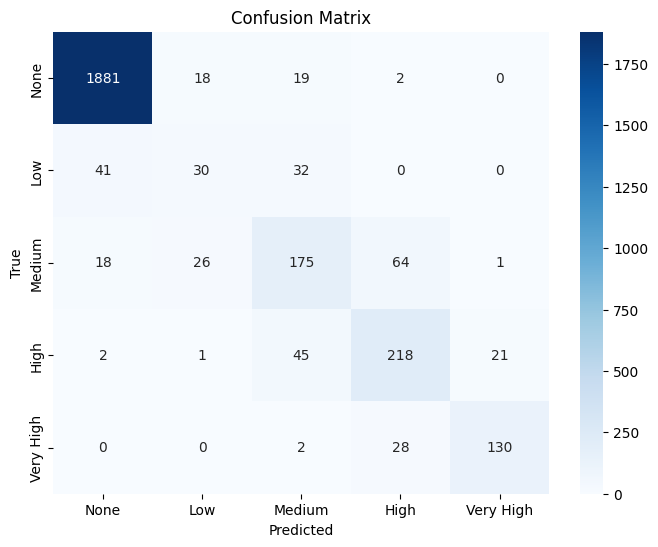

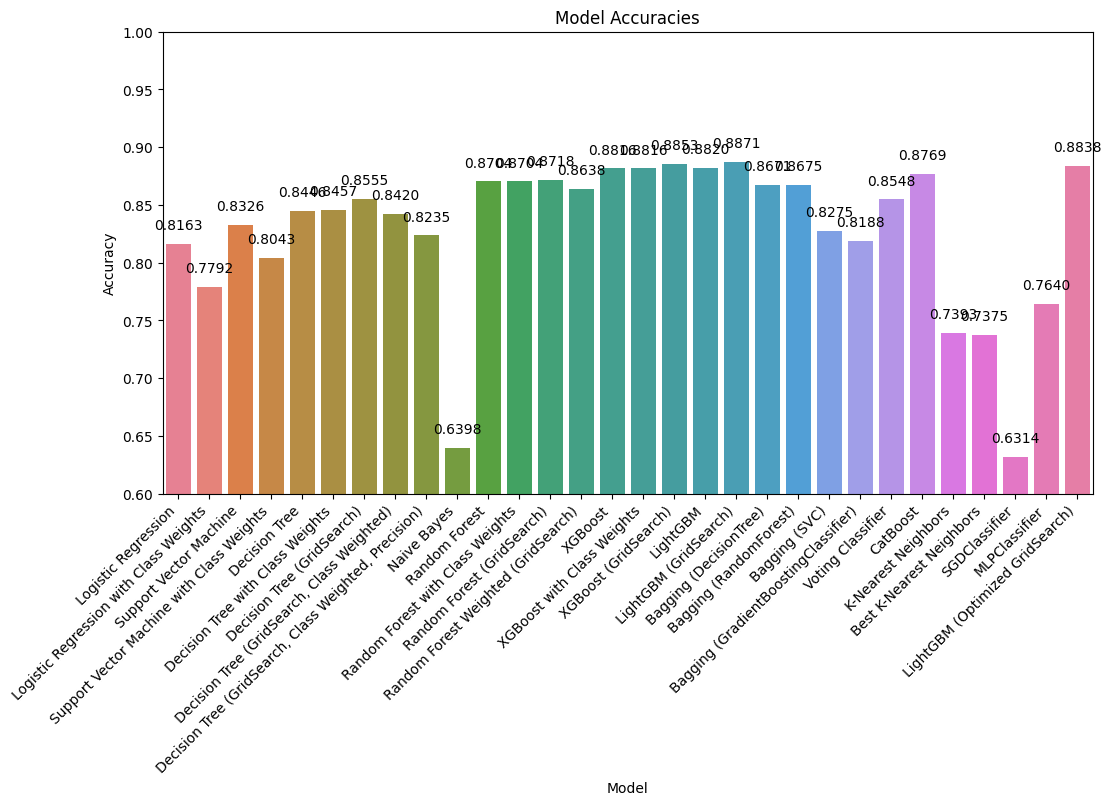

In [79]:
# Initialize the LightGBM model with additional parameters
lgb_model_optimized = lgb.LGBMClassifier(
    random_state=state_value,
    num_leaves=31,  # Set num_leaves explicitly
    min_child_weight=0.001,  # Adjust min_child_weight
    reg_alpha=0.1  # Adjust regularization term
)

# Define the hyperparameter grid with additional options
param_grid_optimized = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [5, 10, 15]
}

# Create GridSearchCV instance
grid_search_lgb_optimized = GridSearchCV(
    lgb_model_optimized, param_grid_optimized, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit the model to the data
grid_search_lgb_optimized.fit(X_train, y_train)

# Get the best parameters
best_params_lgb_optimized = grid_search_lgb_optimized.best_params_
print(f'Best Parameters (LightGBM Optimized): {best_params_lgb_optimized}')

# Make predictions on the test set using the best model
best_lgb_model_optimized = grid_search_lgb_optimized.best_estimator_
y_pred_lgb_optimized = best_lgb_model_optimized.predict(X_test)

# Calculate accuracy
accuracy_lgb_optimized = accuracy_score(y_test, y_pred_lgb_optimized)
print(f'LightGBM Accuracy (Optimized GridSearch): {accuracy_lgb_optimized:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_lgb_optimized, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['LightGBM (Optimized GridSearch)'] = {'model': best_lgb_model_optimized, 'accuracy': accuracy_lgb_optimized}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

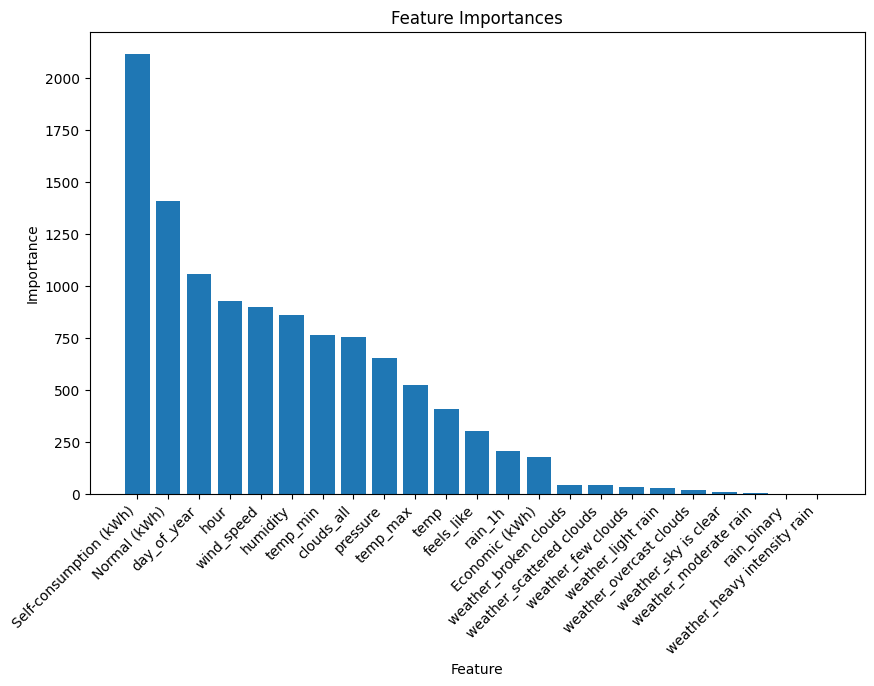

Features with Importance Below Threshold:
                         Feature  Importance
12         weather_broken clouds          44
18      weather_scattered clouds          40
13            weather_few clouds          33
15            weather_light rain          26
17       weather_overcast clouds          20
19          weather_sky is clear           6
16         weather_moderate rain           4
22                   rain_binary           1
14  weather_heavy intensity rain           0


In [88]:
# Get feature importances
feature_importance = lgb_model_optimized.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the bar chart for feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Set the threshold for feature importance
threshold = 150 

# Filter features below the threshold
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]

# Print or display the low-importance features
print("Features with Importance Below Threshold:")
print(low_importance_features)


In [90]:
# Get the names of features to drop
features_to_drop = low_importance_features['Feature'].tolist()

# Drop columns from X_train and X_test
X_train_filtered = X_train.drop(features_to_drop, axis=1)
X_test_filtered = X_test.drop(features_to_drop, axis=1)

# Display the filtered datasets
print("X_train_filtered shape:", X_train_filtered.shape)
print("X_test_filtered shape:", X_test_filtered.shape)

X_train_filtered shape: (8262, 14)
X_test_filtered shape: (2754, 14)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 8262, number of used features: 23
[LightGBM] [Info] Start training from score -2.315008
[LightGBM] [Info] Start training from score -3.223364
[LightGBM] [Info] Start training from score -2.317462
[LightGBM] [Info] Start training from score -0.344029
[LightGBM] [Info] Start training from score -2.919103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

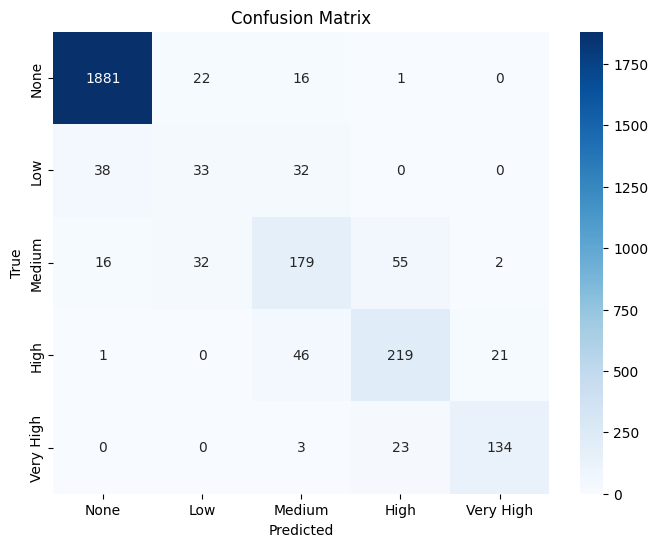

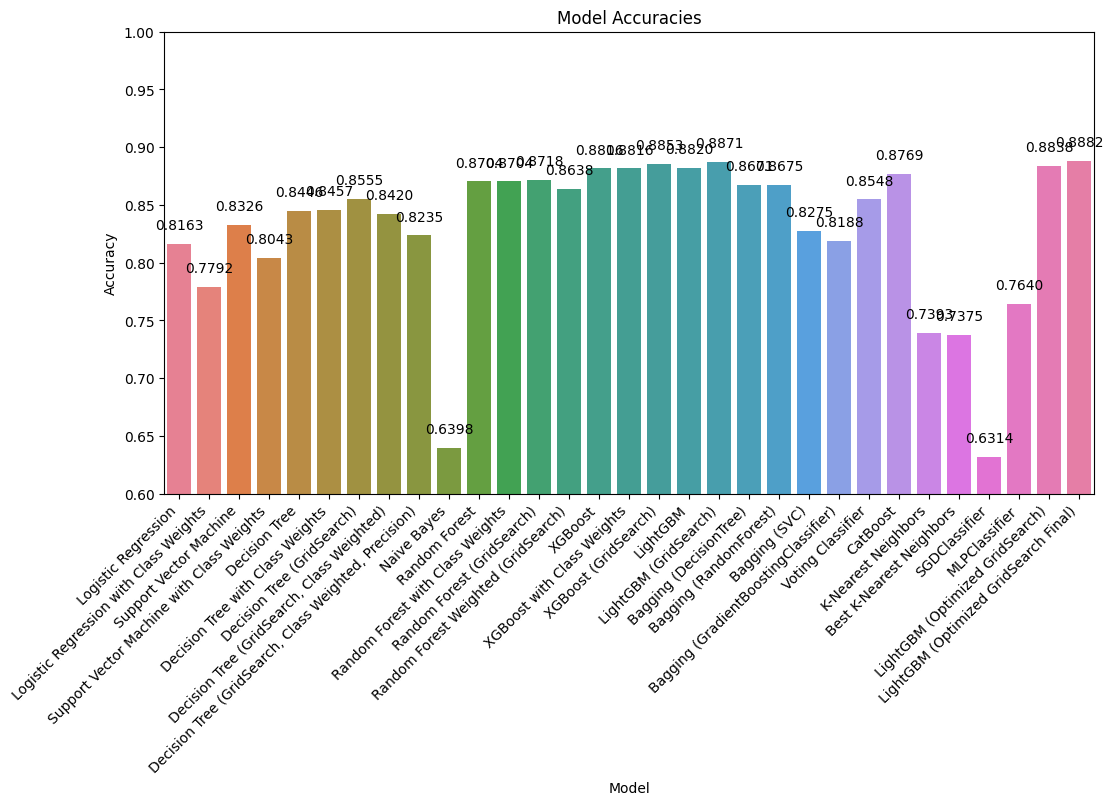

In [94]:
# Initialize the LightGBM model with best parameters
lgb_model_optimized = lgb.LGBMClassifier(
    random_state=state_value,
    learning_rate=0.2,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    min_child_samples=15
)

# Explicitly set num_leaves to suppress the warning
lgb_model_optimized.set_params(num_leaves=31)

# Train the model
lgb_model_optimized.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgb_optimized = lgb_model_optimized.predict(X_test)

# Calculate accuracy
accuracy_lgb_optimized = accuracy_score(y_test, y_pred_lgb_optimized)
print(f'LightGBM Accuracy (Optimized GridSearch): {accuracy_lgb_optimized:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_lgb_optimized, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the model and its accuracy in the Results dictionary
Results['LightGBM (Optimized GridSearch Final)'] = {'model': lgb_model_optimized, 'accuracy': accuracy_lgb_optimized}

# Plot the bar chart of accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 8262, number of used features: 23
[LightGBM] [Info] Start training from score -2.315008
[LightGBM] [Info] Start training from score -3.223364
[LightGBM] [Info] Start training from score -2.317462
[LightGBM] [Info] Start training from score -0.344029
[LightGBM] [Info] Start training from score -2.919103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

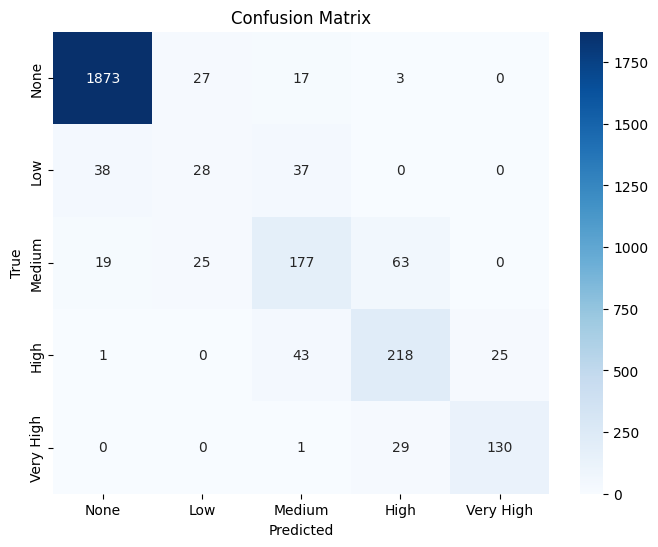

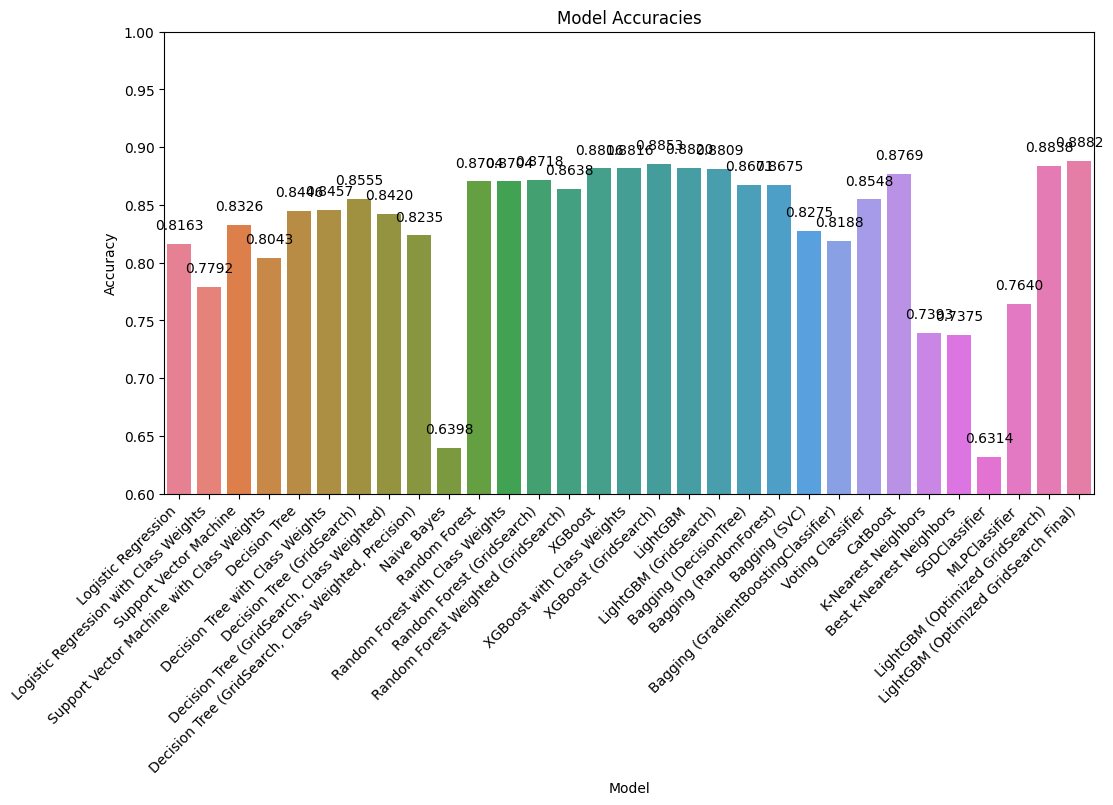

In [95]:
# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=state_value)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.15],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [1, 5, 10]
}

# Create GridSearchCV instance
grid_search_lgb = GridSearchCV(lgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search_lgb.fit(X_train, y_train)

# Get the best parameters
best_params_lgb = grid_search_lgb.best_params_
print(f'Best Parameters (LightGBM): {best_params_lgb}')

# Make predictions on the test set using the best model
best_lgb_model = grid_search_lgb.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'LightGBM Accuracy (GridSearch): {accuracy_lgb:.4f}')

# Print confusion matrix
plot_confusion_matrix(y_test, y_pred_lgb, labels=['None', 'Low', 'Medium', 'High', 'Very High'])

# Save the best model and its accuracy in the Results dictionary
Results['LightGBM (GridSearch)'] = {'model': best_lgb_model, 'accuracy': accuracy_lgb}

# Update the list of models and accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

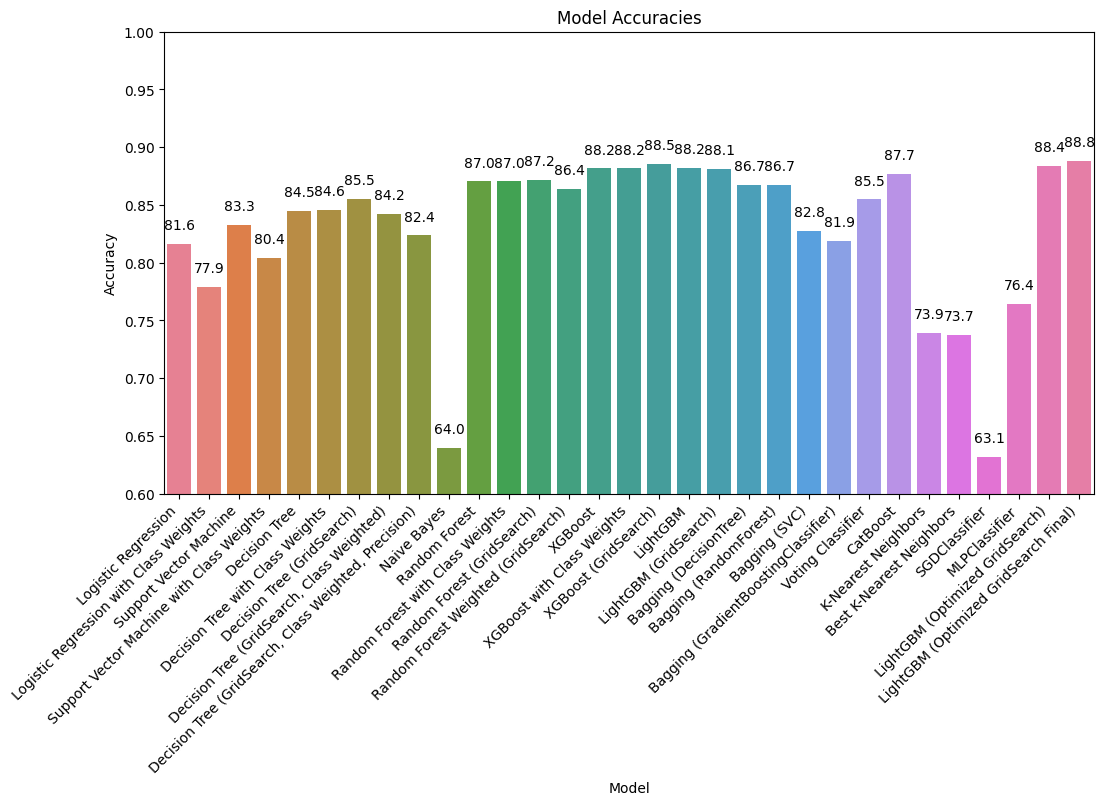

In [101]:
# Final Bar Chart of Accuracies
models = list(Results.keys())
accuracies = [Results[model]['accuracy'] for model in models]
plot_accuracies_bar_graph(models, accuracies)

# **Outputing the predictions on the test set**

In [103]:
# Read the csv containing the test data
test_data = pd.read_csv('datasets/test_merged_filled.csv',na_filter=False, encoding = "latin")

In [104]:
# Drop the features of low importance
test_data = test_data.drop(features_to_drop, axis=1)

In [105]:
# Predict the target variable for the test data on the best model (LightGBM (Optimized GridSearch Final))
y_pred_test = lgb_model_optimized.predict(test_data)